# EEP 467 Homework 2: Breaking CAPTCHAs End-to-End

In lab 2, we have successfully built a pipeline that automatically recognizes CAPTCHAs. So far, the recognition process requires manually identifying contours (and subsequently bounding boxes) around characters using expert rules, before performing classification on extracted character images. This inspires us for possible further improvement: can we use a single neural network to directly identify CAPTCHA characters from CAPTCHA image? In this homework, we will get rid of bounding box identification and build an end-to-end neural network model.

## Before You Start

1. You can discuss on Discord if you have questions and want to seek help; however, please try your best to **limit the scope of your question** and **avoid asking directly for answers**. You should also **avoid copy-pasting answers and code** from others.
2. You are allowed to use AI assistants for help. In this case, you should **acknowledge your use of AI assistant** by providing its **name as well as how it helps you** to obtain your answer. Again, you **should not copy-paste from the response** of the AI assistant.

## Pre-processing

First of all, make sure you have installed all dependencies needed for this homework. The list of depedencies is similar to lab 3, except that we will ditch OpenCV and `imutils`, and instead use PyTorch Vision (`torchvision`) for some of our preprocessing work:

In [1]:
# %pip install matplotlib scikit-learn tqdm

# # If using Anaconda / Miniconda, install PyTorch and PyTorch Vision with:
# # %conda install conda-forge::pytorch-gpu conda-forge::torchvision # (CPU and GPU support)
# # %conda install conda-forge::pytorch conda-forge::torchvision # (CPU-only support)

# # If using Pip, install PyTorch and PyTorch Vision with:
# %pip install torch torchvision
# # When installing PyTorch with GPU support, refer to https://pytorch.org/get-started/locally/
# # if your CUDA version differs from the default CUDA version of the current version PyTorch package.

Once you are ready, we will start with data pre-processing step where we load all CAPTCHA images into memory. There are a few utilities in `torchvision` which can help us do the job:

In [2]:
import os

import torch
from torchvision.datasets.folder import IMG_EXTENSIONS
from torchvision.io import ImageReadMode, decode_image

# CAPTCHA images directory
CAPTCHA_IMAGES_DIR = "captcha-images"

# CAPTCHA images
captcha_images = []
# CAPTCHA texts
captcha_texts = []

## [ TODO ]
# 1) Load all CAPTCHA images from `CAPTCHA_IMAGES_DIR` into `captcha_images`
#    (Hint: use `os.scandir` to iterate over directory entries and check file extensions with `IMG_EXTENSIONS`)
#    (Hint: use `torchvision.io.decode_image` to load images in grayscale mode)
#    (Note: your code should ignore non-image files)

images = []
texts = []

# Handle both layouts:
# - captcha-images/*.png
# - captcha-images/captcha-images/*.png
scan_dir = CAPTCHA_IMAGES_DIR
if not any(entry.is_file() for entry in os.scandir(scan_dir)):
    nested_dir = os.path.join(CAPTCHA_IMAGES_DIR, "captcha-images")
    if os.path.isdir(nested_dir):
        scan_dir = nested_dir

for entry in sorted(os.scandir(scan_dir), key=lambda e: e.name):
    if not entry.is_file():
        continue
    
    # check extension
    _, ext = os.path.splitext(entry.name)
    if ext.lower() not in IMG_EXTENSIONS:
        continue

    # load image in grayscale
    img = decode_image(entry.path, mode=ImageReadMode.GRAY)  # (1, H, W)

    images.append(img)
    
    # filename without extension
    text = os.path.splitext(entry.name)[0]
    texts.append(text)

if len(images) == 0:
    raise RuntimeError(
        f"No CAPTCHA images found in '{scan_dir}'. "
        "Check CAPTCHA_IMAGES_DIR and dataset extraction path."
    )

# 2) Stack all CAPTCHA images into a PyTorch tensor

captcha_images = torch.stack(images, dim=0)  # (N, 1, 24, 72)

# 3) Load all CAPTCHA texts (filenames without extension) into `captcha_texts`
#    (Items in `captcha_images` and `captcha_texts` should match)

captcha_texts = texts



assert isinstance(captcha_images, torch.Tensor), "`captcha_images` must be a PyTorch tensor!"
assert captcha_images.ndim==4, "`captcha_images` should be a 4D tensor!"
assert captcha_images.shape[1:]==(1, 24, 72), "`captcha_images` should have shape (n_images, 1, h, w)!"

assert len(captcha_images)==len(captcha_texts), \
    "`captcha_images` should have the same number of elements as `captcha_texts`!"
assert all(isinstance(text, str) and len(text)==4 for text in captcha_texts), \
    "all `captcha_texts` should be strings with four letters!"

Then, we split all CAPTCHA images and texts into training-validation and test sets:

In [3]:
from sklearn.model_selection import train_test_split

# Training-validation-test split seed
TVT_SPLIT_SEED = 31528476

# Split dataset into training and test sets
captcha_images_tv, captcha_images_test, captcha_texts_tv, captcha_texts_test = train_test_split(
    captcha_images, captcha_texts, test_size=0.2, random_state=TVT_SPLIT_SEED
)

Next, we encode each character in the CAPTCHA text as class indices:

In [4]:
from sklearn.preprocessing import LabelEncoder
import hw2_util

# Label encoder
le = LabelEncoder()

## [ TODO ]
# 1) Flatten training-validation CAPTCHA texts into list of characters
#    (Hint: `hw2_util.flatten` can help you with that)
chars_tv = [c for text in captcha_texts_tv for c in text]
# 2) Fit and transform characters into class indices using `LabelEncoder`
char_indices_tv = le.fit_transform(chars_tv)

# 3) Save number of classes (distinct characters) in `n_classes`
n_classes = len(le.classes_)

# 4) Convert class indices to PyTorch tensor and reshape as `texts_class_indices_tv`
#    (The shape of `texts_class_indices_tv` should be (n_images, 4))
texts_class_indices_tv = torch.tensor(char_indices_tv, dtype=torch.long).view(-1, 4)

assert isinstance(texts_class_indices_tv, torch.Tensor), "`texts_class_indices_tv` must be a PyTorch tensor!"
assert texts_class_indices_tv.ndim==2, "`texts_class_indices_tv` must have two dimensions!"
assert texts_class_indices_tv.shape==(len(captcha_texts_tv), 4), \
    "Shape of `texts_class_indices_tv` should be (n_images, 4)!"

Then, we further split training-validation set into two parts:

In [5]:
# Split training set further into training and validation sets
captcha_images_train, captcha_images_vali, texts_class_indices_train, texts_class_indices_vali = train_test_split(
    captcha_images_tv, texts_class_indices_tv, test_size=0.25, random_state=TVT_SPLIT_SEED
)

## Data Augmentation

The following step will be unique to this homework: we will perform **data augmentation** using PyTorch's [`transforms.Compose`](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.Compose.html) and [`transforms.RandomAffine`](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.RandomAffine.html). Here we will configure the `RandomAffine` transform to **apply the following random effects** to our CAPTCHAs:

* Random rotation (at most 5 degrees)
* Random horizontal and vertical shifting (at most 10%)
* Random shearing (at most 5 degrees)
* Random zooming in or out (at most 10%)

Besides, we will also **pre-process the image pixels** in the `RescaleInvertPixels` custom transform. Here we need to first **rescale the grayscale values** to $[0, 1]$ range and then **invert the grayscales**. We will chain the `RescaleInvertPixels` transform together with the `RandomAffine` transform using `Compose` to create a complete augmentation pipeline.

Below code will create such a transform pipeline, and preview its effects on a few sample CAPTCHAs:

Figure(2000x500)
Figure(2000x500)


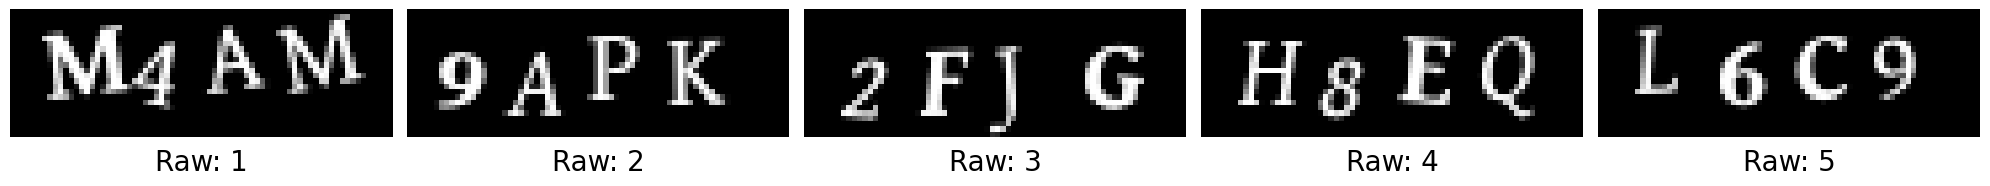

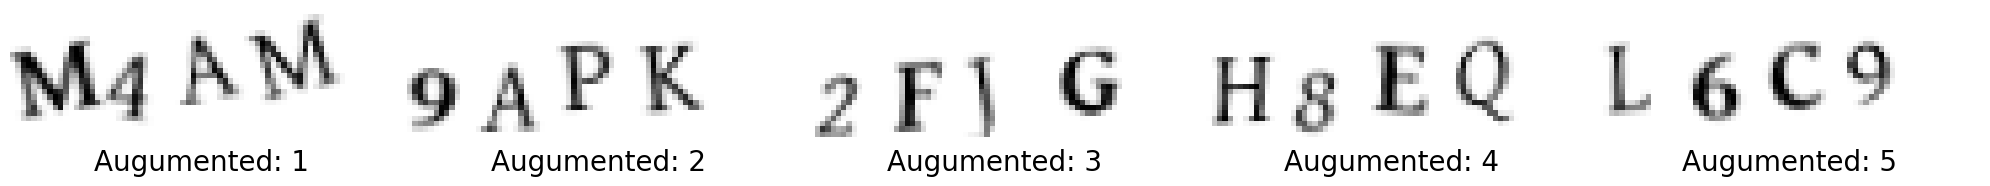

In [6]:
from torch import nn
from torchvision.transforms import Compose, InterpolationMode, RandomAffine

class RescaleInvertPixels(nn.Module):
    def forward(self, raw_image):
        ## [ TODO ]
        # 1) Rescale pixel grayscale values to [0, 1]
        rescaled_image = raw_image.float() / 255.0
        # 2) Invert the grayscales of the image (darker becomes lighter, and vice versa)
        inverted_image = 1.0 - rescaled_image
        # 3) Return modified grayscales
        return inverted_image

## [ TODO ]
# Create a transform pipeline using `Compose` with:
# 1) `RescaleInvertPixels()` for preprocessing
captcha_transform = Compose([RescaleInvertPixels()])
# 2) `RandomAffine` with the following random effects:
#    - Rotation: at most 5 degrees
#    - Horizontal and vertical shift: at most 10%
#    - Zooming: at most 10% (scale between 0.9 and 1.1)
#    - Shearing: at most 5 degrees
#    - Use `InterpolationMode.BILINEAR` for interpolation
#

# Choose parameters such that CAPTCHAs are moderately distorted but still recognizable.
captcha_transform = Compose([
    RescaleInvertPixels(),
    RandomAffine(
        degrees=5,
        translate=(0.1, 0.1),
        scale=(0.9, 1.1),
        shear=5,
        interpolation=InterpolationMode.BILINEAR
    )
])

# Select a few images for preview
preview_orig = captcha_images_train[:5]
# Generate a few transformed CAPTCHA images for preview
preview_trans = captcha_transform(preview_orig)

# Preview original and transformed CAPTCHAs
hw2_util.print_images(
    preview_orig.squeeze(-3),
    texts=[f"Raw: {i+1}" for i in range(5)]
)
hw2_util.print_images(
    preview_trans.squeeze(-3),
    texts=[f"Augumented: {i+1}" for i in range(5)]
)

Apart from the inversion of grayscale, you should be able to observe slight differences between original and transformed images. These transformed CAPTCHAs should still be easily recognizable, though.

## Training

From now on, we will shift our focus to the end-to-end neural network model. We assume our neural network model takes a bunch of CAPTCHA images (known as a batch) as input and outputs logits for each of the four character positions. In other words, if we have `n_classes` distinct characters in all CAPTCHAs, the output of our model would be a PyTorch tensor of shape `(batch_size, 4, n_classes)`. From each position's logits, we choose the character with the highest logit value (using the `argmax` operator), and we define a correct prediction as the one where all four characters are correctly predicted.

Our first task is to implement custom loss and accuracy functions for our task, since PyTorch's built-in functions expect different output formats. Both `pred_logits` (Raw model outputs) and `actual_class_indices` (Ground truth class indices) are batch tensors of shape `(batch_size, 4, n_classes)` and `(batch_size, 4)` respectively. Here we use PyTorch operations to compute our custom loss and accuracy metric:

In [7]:
from torch.nn import functional as f

def multi_char_loss(pred_logits, actual_class_indices):
    """ Compute the mean cross entropy loss of multiple CAPTCHA characters recognition. """
    return f.cross_entropy(pred_logits.flatten(0, 1), actual_class_indices.flatten())

def multi_char_acc(pred_logits, actual_class_indices):
    """ Compute the accuracy of multiple CAPTCHA characters recognition. """
    # Compute predicted class indices (most likely class / largest logits)
    pred_class_indices = pred_logits.argmax(-1)
    # Compute prediction accuracy for ALL four characters in a CAPTCHA, then average across samples
    return (pred_class_indices==actual_class_indices).all(-1).float().mean()

Next, we will complete `build_model` function which is responsible for building the neural network model. The neural network starts with several "convolution blocks" as usual, each of which contains a convolution layer for feature extraction and a max pooling layer for dimensionality reduction. The latter part of the network is however different from lab 3 in that **we replace regular fully-connected layers (implemented with linear layers) with "zone-wise" fully-connected layers (implemented with convolution layers)**.

We also substitute the regular cross-entropy loss for our custom `multi_char_loss` and make use of our custom accuracy metric, `multi_char_acc`, due to the unique output format of our model.

Below is the structure of our network:

In [8]:
from hw2_util import Transpose

def build_model(n_classes):
    """ Build the neural network model for CAPTCHA classification. """
    return nn.Sequential(
        # [ TODO ]
        # Complete the model architecture according to the specifications shown above and below:
        #
        # First convolution block: (*, 1, 24, 72) -Conv2d-> (*, 10, 24, 72) -ReLU-> (*, 10, 24, 72) -MaxPool2d-> (*, 10, 12, 36)
        # 1) Convolution layer: 1 input channel, 10 output channels, 5*5 kernel, padded to maintain same shape
        nn.Conv2d(1, 10, kernel_size=5, padding=2),
        # 2) ReLU activation layer
        nn.ReLU(),
        # 3) Max pooling layer: 2*2 kernel
        nn.MaxPool2d(kernel_size=2, stride=2),
        
        # Second convolution block: (*, 10, 12, 36) -Conv2d-> (*, 40, 12, 36) -ReLU-> (*, 40, 12, 36) -MaxPool2d-> (*, 40, 6, 18)
        nn.Conv2d(10, 40, kernel_size=5, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # Third convolution block: (*, 40, 6, 18) -Conv2d-> (*, 100, 6, 18) -ReLU-> (*, 100, 6, 18) -MaxPool2d-> (*, 100, 3, 9)
        nn.Conv2d(40, 100, kernel_size=5, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # First "zone-wise" fully-connected block: (*, 100, 3, 9) -Conv2d-> (*, 800, 1, 4) -ReLU-> (*, 800, 1, 4)
        # Convolution layer: 100 input channels, 800 output channels, 3*3 kernel, horizontal stride set to 2 to obtain 4 zones, no padding
        nn.Conv2d(100, 800, kernel_size=(3, 3), stride=(1, 2)),
        nn.ReLU(),

        # Second "zone-wise" fully-connected layer: (*, 800, 1, 4) -Conv2d-> (*, n_classes, 1, 4)
        # Convolution layer: `n_classes` channels, 1*1 kernel, no padding, used for dimensionality reduction
        nn.Conv2d(800, n_classes, kernel_size=(1, 1)),

        # Reshape and transpose dimensions: (*, n_classes, 1, 4) -Flatten-> (*, n_classes, 4) -`lab_3_helpers.Transpose`-> (*, 4, n_classes)
        nn.Flatten(start_dim=2),
        Transpose(1, 2)
    )

To facilitate efficient data loading and transformation, we will create a custom PyTorch [`Dataset`](https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) class called `CAPTCHADataset`. This class will handle loading CAPTCHA images and their corresponding labels, and apply the data augmentation transforms on-the-fly during training. By implementing the standard PyTorch [`Dataset`](https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) interface, we can leverage PyTorch's [`DataLoader`](https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for efficient batch processing and parallel data loading:

In [9]:
from torch.utils.data import Dataset

class CAPTCHADataset(Dataset):
    def __init__(self, captcha_images, texts_features, captcha_transform):
        self.captcha_images = captcha_images
        self.texts_features = texts_features
        self.captcha_transform = captcha_transform

    def __len__(self):
        return len(self.captcha_images)

    def __getitem__(self, idx):
        captcha_image = self.captcha_transform(self.captcha_images[idx])
        text_features = self.texts_features[idx]

        return captcha_image, text_features

Finally, the `train_model` function implements the standard PyTorch training loop. For each epoch, it performs forward passes on batches from the training set, computes loss using `multi_char_loss`, backpropagates gradients, and updates model parameters. After each epoch, it evaluates the model on the validation set. Data augmentation is applied on-the-fly via the `CAPTCHADataset` during both training and validation.

In [10]:
from tqdm import tqdm
from torch.utils.data import DataLoader

def train_model(model, optimizer, dataset_train, dataset_vali, batch_size=32, n_epochs=50, device=None):
    # Detect device from model parameters if not provided
    device = device or next(iter(model.parameters())).device

    ## [ TODO ]
    # 1) Create training data loader from `dataset_train` with shuffling enabled
    # 2) Create validation data loader from `dataset_vali`
    # (Note: set the batch size for both loaders)
    loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    loader_vali = DataLoader(dataset_vali, batch_size=batch_size, shuffle=False)

    history = []

    print("Starting training ...")
    for i in range(n_epochs):
        # In every epoch, do training first ...
        loss_train = 0.
        acc_train = 0.

        print(f"Starting training epoch {i+1}/{n_epochs} ...")
        for captcha_images_batch, texts_class_indices_batch in tqdm(loader_train):
            ## [ TODO ]
            # Complete the training inner loop:
            #
            # 1) Move images and labels to the target device
            captcha_images_batch = captcha_images_batch.to(device)
            texts_class_indices_batch = texts_class_indices_batch.to(device)
            # 2) Perform forward pass to get logits
            logits = model(captcha_images_batch)
            # 3) Compute loss using `multi_char_loss` and accuracy using `multi_char_acc`
            loss = multi_char_loss(logits, texts_class_indices_batch)
            acc = multi_char_acc(logits, texts_class_indices_batch)
            # 4) Perform backward propagation
            loss.backward()
            # 5) Update model parameters by taking an optimizer step
            optimizer.step()
            # 6) Clear model gradients
            optimizer.zero_grad()
            # 7) Accumulate loss and accuracy
            #    (Hint: Detach loss tensor before accumulation)
            #    (Hint: Move tensors to CPU for accumulation)
            loss_train += loss.detach().cpu()
            acc_train += acc.detach().cpu()

        loss_train = (loss_train/len(loader_train)).item()
        acc_train = (acc_train/len(loader_train)).item()
        # Report loss and metrics
        print(f"Ending training of epoch {i+1}/{n_epochs}: loss: {loss_train}, accuracy: {acc_train}")

        # Then evaluate the model
        loss_vali = 0.
        acc_vali = 0.

        # Put model in validation mode
        model.eval()

        print(f"Starting validation epoch {i+1}/{n_epochs} ...")
        for captcha_images_batch, texts_class_indices_batch in tqdm(loader_vali):
            ## [ TODO ]
            # Complete the validation inner loop:
            #
            # 1) Move images and labels to the target device
            captcha_images_batch = captcha_images_batch.to(device)
            texts_class_indices_batch = texts_class_indices_batch.to(device)
            # 2) Perform forward pass to get logits
            logits = model(captcha_images_batch)
            # 3) Compute loss using `multi_char_loss` and accuracy using `multi_char_acc`
            loss = multi_char_loss(logits, texts_class_indices_batch)
            acc = multi_char_acc(logits, texts_class_indices_batch)
            # 4) Accumulate loss and accuracy (move tensors to CPU for accumulation)
            loss_vali += loss.detach().cpu()
            acc_vali += acc.detach().cpu()

        loss_vali = (loss_vali/len(loader_vali)).item()
        acc_vali = (acc_vali/len(loader_vali)).item()
        # Report loss and metrics
        print(f"Ending validation of epoch {i+1}/{n_epochs}: loss: {loss_vali}, accuracy: {acc_vali}")

        # Save epoch metrics
        history.append({
            "epoch": i+1,
            "loss_train": loss_train,
            "acc_train": acc_train,
            "loss_vali": loss_vali,
            "acc_vali": acc_vali
        })

        # Put model back in training mode
        model.train()

    return history

Ok, it's time to put everything together. We will build our model, train our model for some epochs and save it as `model-basic-params.pt`. For model training, you may adjust the number of epochs and / or batch size if necessary, to ensure that you achieve at least 80% of accuracy on the training set and at least 70% of accuracy on the validation set.

In [11]:
from torch.optim import AdamW

# Detect best PyTorch device
# (Prefer GPU devices such as CUDA or MPS, then fall back to CPU as last resort)
torch_device = hw2_util.get_torch_device()

# Build training and validation datasets
dataset_train = CAPTCHADataset(captcha_images_train, texts_class_indices_train, captcha_transform)
dataset_vali = CAPTCHADataset(captcha_images_vali, texts_class_indices_vali, captcha_transform)

# Build a basic end-to-end CAPTCHA model
model_basic = build_model(n_classes)
# Move model to PyTorch device
model_basic = model_basic.to(torch_device)
# Build an AdamW optimizer with model parameters
optimizer = AdamW(model_basic.parameters(), lr=0.001)

# Show model structure
print("Model structure:")
print(model_basic)
print()

# Train the basic model for 100 epochs
history_basic = train_model(model_basic, optimizer, dataset_train, dataset_vali)
# Save the basic model in file
torch.save(model_basic.state_dict(), "./model-basic-params.pt")

Model structure:
Sequential(
  (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(10, 40, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(40, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(100, 800, kernel_size=(3, 3), stride=(1, 2))
  (10): ReLU()
  (11): Conv2d(800, 32, kernel_size=(1, 1), stride=(1, 1))
  (12): Flatten(start_dim=2, end_dim=-1)
  (13): Transpose(dim0=1, dim1=2)
)

Starting training ...
Starting training epoch 1/50 ...


100%|██████████| 22/22 [00:00<00:00, 47.51it/s]


Ending training of epoch 1/50: loss: 3.410372734069824, accuracy: 0.0
Starting validation epoch 1/50 ...


100%|██████████| 8/8 [00:00<00:00, 147.61it/s]


Ending validation of epoch 1/50: loss: 3.3367154598236084, accuracy: 0.0
Starting training epoch 2/50 ...


100%|██████████| 22/22 [00:00<00:00, 101.38it/s]


Ending training of epoch 2/50: loss: 3.2808313369750977, accuracy: 0.0
Starting validation epoch 2/50 ...


100%|██████████| 8/8 [00:00<00:00, 166.66it/s]


Ending validation of epoch 2/50: loss: 3.1630806922912598, accuracy: 0.0
Starting training epoch 3/50 ...


100%|██████████| 22/22 [00:00<00:00, 105.30it/s]


Ending training of epoch 3/50: loss: 3.0423941612243652, accuracy: 0.0
Starting validation epoch 3/50 ...


100%|██████████| 8/8 [00:00<00:00, 166.72it/s]


Ending validation of epoch 3/50: loss: 2.946789026260376, accuracy: 0.0
Starting training epoch 4/50 ...


100%|██████████| 22/22 [00:00<00:00, 103.45it/s]


Ending training of epoch 4/50: loss: 2.850752115249634, accuracy: 0.005050505045801401
Starting validation epoch 4/50 ...


100%|██████████| 8/8 [00:00<00:00, 165.70it/s]


Ending validation of epoch 4/50: loss: 2.7018589973449707, accuracy: 0.00390625
Starting training epoch 5/50 ...


100%|██████████| 22/22 [00:00<00:00, 104.21it/s]


Ending training of epoch 5/50: loss: 2.559065103530884, accuracy: 0.0028409091755747795
Starting validation epoch 5/50 ...


100%|██████████| 8/8 [00:00<00:00, 110.84it/s]


Ending validation of epoch 5/50: loss: 2.4323160648345947, accuracy: 0.0078125
Starting training epoch 6/50 ...


100%|██████████| 22/22 [00:00<00:00, 104.50it/s]


Ending training of epoch 6/50: loss: 2.3571078777313232, accuracy: 0.005681818351149559
Starting validation epoch 6/50 ...


100%|██████████| 8/8 [00:00<00:00, 162.05it/s]


Ending validation of epoch 6/50: loss: 2.3328187465667725, accuracy: 0.0078125
Starting training epoch 7/50 ...


100%|██████████| 22/22 [00:00<00:00, 106.14it/s]


Ending training of epoch 7/50: loss: 2.0764319896698, accuracy: 0.015625
Starting validation epoch 7/50 ...


100%|██████████| 8/8 [00:00<00:00, 163.27it/s]


Ending validation of epoch 7/50: loss: 2.0129096508026123, accuracy: 0.01171875
Starting training epoch 8/50 ...


100%|██████████| 22/22 [00:00<00:00, 110.02it/s]


Ending training of epoch 8/50: loss: 1.7790757417678833, accuracy: 0.03693181648850441
Starting validation epoch 8/50 ...


100%|██████████| 8/8 [00:00<00:00, 173.92it/s]


Ending validation of epoch 8/50: loss: 1.6728181838989258, accuracy: 0.0625
Starting training epoch 9/50 ...


100%|██████████| 22/22 [00:00<00:00, 110.08it/s]


Ending training of epoch 9/50: loss: 1.4823393821716309, accuracy: 0.11868686974048615
Starting validation epoch 9/50 ...


100%|██████████| 8/8 [00:00<00:00, 175.89it/s]


Ending validation of epoch 9/50: loss: 1.4153822660446167, accuracy: 0.1015625
Starting training epoch 10/50 ...


100%|██████████| 22/22 [00:00<00:00, 110.00it/s]


Ending training of epoch 10/50: loss: 1.233587622642517, accuracy: 0.19696970283985138
Starting validation epoch 10/50 ...


100%|██████████| 8/8 [00:00<00:00, 166.67it/s]


Ending validation of epoch 10/50: loss: 1.2237281799316406, accuracy: 0.21875
Starting training epoch 11/50 ...


100%|██████████| 22/22 [00:00<00:00, 111.97it/s]


Ending training of epoch 11/50: loss: 1.0438529253005981, accuracy: 0.2678346037864685
Starting validation epoch 11/50 ...


100%|██████████| 8/8 [00:00<00:00, 170.24it/s]


Ending validation of epoch 11/50: loss: 1.121934175491333, accuracy: 0.2135416716337204
Starting training epoch 12/50 ...


100%|██████████| 22/22 [00:00<00:00, 112.29it/s]


Ending training of epoch 12/50: loss: 0.9406023025512695, accuracy: 0.29845330119132996
Starting validation epoch 12/50 ...


100%|██████████| 8/8 [00:00<00:00, 177.78it/s]


Ending validation of epoch 12/50: loss: 0.8746085166931152, accuracy: 0.3268229067325592
Starting training epoch 13/50 ...


100%|██████████| 22/22 [00:00<00:00, 109.26it/s]


Ending training of epoch 13/50: loss: 0.7578232288360596, accuracy: 0.4171401262283325
Starting validation epoch 13/50 ...


100%|██████████| 8/8 [00:00<00:00, 173.91it/s]


Ending validation of epoch 13/50: loss: 0.7276695966720581, accuracy: 0.3828125
Starting training epoch 14/50 ...


100%|██████████| 22/22 [00:00<00:00, 110.04it/s]


Ending training of epoch 14/50: loss: 0.705439031124115, accuracy: 0.4444444477558136
Starting validation epoch 14/50 ...


100%|██████████| 8/8 [00:00<00:00, 164.91it/s]


Ending validation of epoch 14/50: loss: 0.707718014717102, accuracy: 0.4127604067325592
Starting training epoch 15/50 ...


100%|██████████| 22/22 [00:00<00:00, 102.59it/s]


Ending training of epoch 15/50: loss: 0.6215909719467163, accuracy: 0.5394570827484131
Starting validation epoch 15/50 ...


100%|██████████| 8/8 [00:00<00:00, 168.77it/s]


Ending validation of epoch 15/50: loss: 0.7093424797058105, accuracy: 0.515625
Starting training epoch 16/50 ...


100%|██████████| 22/22 [00:00<00:00, 109.45it/s]


Ending training of epoch 16/50: loss: 0.5544224977493286, accuracy: 0.5830177068710327
Starting validation epoch 16/50 ...


100%|██████████| 8/8 [00:00<00:00, 177.78it/s]


Ending validation of epoch 16/50: loss: 0.5979906320571899, accuracy: 0.50390625
Starting training epoch 17/50 ...


100%|██████████| 22/22 [00:00<00:00, 108.91it/s]


Ending training of epoch 17/50: loss: 0.5088047385215759, accuracy: 0.6153724789619446
Starting validation epoch 17/50 ...


100%|██████████| 8/8 [00:00<00:00, 166.66it/s]


Ending validation of epoch 17/50: loss: 0.5357766151428223, accuracy: 0.5026041865348816
Starting training epoch 18/50 ...


100%|██████████| 22/22 [00:00<00:00, 105.85it/s]


Ending training of epoch 18/50: loss: 0.4266834557056427, accuracy: 0.6865530610084534
Starting validation epoch 18/50 ...


100%|██████████| 8/8 [00:00<00:00, 162.54it/s]


Ending validation of epoch 18/50: loss: 0.5117031931877136, accuracy: 0.6263020634651184
Starting training epoch 19/50 ...


100%|██████████| 22/22 [00:00<00:00, 107.76it/s]


Ending training of epoch 19/50: loss: 0.43411457538604736, accuracy: 0.6952335834503174
Starting validation epoch 19/50 ...


100%|██████████| 8/8 [00:00<00:00, 165.49it/s]


Ending validation of epoch 19/50: loss: 0.5459716320037842, accuracy: 0.5338541865348816
Starting training epoch 20/50 ...


100%|██████████| 22/22 [00:00<00:00, 109.62it/s]


Ending training of epoch 20/50: loss: 0.41251686215400696, accuracy: 0.678661584854126
Starting validation epoch 20/50 ...


100%|██████████| 8/8 [00:00<00:00, 160.39it/s]


Ending validation of epoch 20/50: loss: 0.45973801612854004, accuracy: 0.6028645634651184
Starting training epoch 21/50 ...


100%|██████████| 22/22 [00:00<00:00, 101.92it/s]


Ending training of epoch 21/50: loss: 0.3685542345046997, accuracy: 0.7114899158477783
Starting validation epoch 21/50 ...


100%|██████████| 8/8 [00:00<00:00, 162.93it/s]


Ending validation of epoch 21/50: loss: 0.4114117920398712, accuracy: 0.62890625
Starting training epoch 22/50 ...


100%|██████████| 22/22 [00:00<00:00, 95.99it/s]


Ending training of epoch 22/50: loss: 0.3450089693069458, accuracy: 0.7013888955116272
Starting validation epoch 22/50 ...


100%|██████████| 8/8 [00:00<00:00, 166.72it/s]


Ending validation of epoch 22/50: loss: 0.420645534992218, accuracy: 0.6653645634651184
Starting training epoch 23/50 ...


100%|██████████| 22/22 [00:00<00:00, 105.77it/s]


Ending training of epoch 23/50: loss: 0.4114469587802887, accuracy: 0.6720328330993652
Starting validation epoch 23/50 ...


100%|██████████| 8/8 [00:00<00:00, 170.20it/s]


Ending validation of epoch 23/50: loss: 0.4463522434234619, accuracy: 0.6875
Starting training epoch 24/50 ...


100%|██████████| 22/22 [00:00<00:00, 108.90it/s]


Ending training of epoch 24/50: loss: 0.3225383460521698, accuracy: 0.7370581030845642
Starting validation epoch 24/50 ...


100%|██████████| 8/8 [00:00<00:00, 159.88it/s]


Ending validation of epoch 24/50: loss: 0.40069645643234253, accuracy: 0.6875
Starting training epoch 25/50 ...


100%|██████████| 22/22 [00:00<00:00, 108.90it/s]


Ending training of epoch 25/50: loss: 0.32889458537101746, accuracy: 0.7383207082748413
Starting validation epoch 25/50 ...


100%|██████████| 8/8 [00:00<00:00, 166.65it/s]


Ending validation of epoch 25/50: loss: 0.4320511817932129, accuracy: 0.7083333134651184
Starting training epoch 26/50 ...


100%|██████████| 22/22 [00:00<00:00, 112.70it/s]


Ending training of epoch 26/50: loss: 0.2523212134838104, accuracy: 0.7902461886405945
Starting validation epoch 26/50 ...


100%|██████████| 8/8 [00:00<00:00, 177.28it/s]


Ending validation of epoch 26/50: loss: 0.37839391827583313, accuracy: 0.70703125
Starting training epoch 27/50 ...


100%|██████████| 22/22 [00:00<00:00, 112.36it/s]


Ending training of epoch 27/50: loss: 0.26660144329071045, accuracy: 0.7733585834503174
Starting validation epoch 27/50 ...


100%|██████████| 8/8 [00:00<00:00, 170.05it/s]


Ending validation of epoch 27/50: loss: 0.2872443199157715, accuracy: 0.7734375
Starting training epoch 28/50 ...


100%|██████████| 22/22 [00:00<00:00, 109.63it/s]


Ending training of epoch 28/50: loss: 0.2562159299850464, accuracy: 0.7922979593276978
Starting validation epoch 28/50 ...


100%|██████████| 8/8 [00:00<00:00, 160.00it/s]


Ending validation of epoch 28/50: loss: 0.3107265830039978, accuracy: 0.7122395634651184
Starting training epoch 29/50 ...


100%|██████████| 22/22 [00:00<00:00, 106.16it/s]


Ending training of epoch 29/50: loss: 0.23212911188602448, accuracy: 0.8279672265052795
Starting validation epoch 29/50 ...


100%|██████████| 8/8 [00:00<00:00, 162.68it/s]


Ending validation of epoch 29/50: loss: 0.3710747957229614, accuracy: 0.72265625
Starting training epoch 30/50 ...


100%|██████████| 22/22 [00:00<00:00, 111.67it/s]


Ending training of epoch 30/50: loss: 0.250725120306015, accuracy: 0.8267045617103577
Starting validation epoch 30/50 ...


100%|██████████| 8/8 [00:00<00:00, 176.47it/s]


Ending validation of epoch 30/50: loss: 0.26407545804977417, accuracy: 0.7578125
Starting training epoch 31/50 ...


100%|██████████| 22/22 [00:00<00:00, 109.45it/s]


Ending training of epoch 31/50: loss: 0.25554990768432617, accuracy: 0.8068181872367859
Starting validation epoch 31/50 ...


100%|██████████| 8/8 [00:00<00:00, 166.18it/s]


Ending validation of epoch 31/50: loss: 0.23296506702899933, accuracy: 0.81640625
Starting training epoch 32/50 ...


100%|██████████| 22/22 [00:00<00:00, 113.53it/s]


Ending training of epoch 32/50: loss: 0.20438961684703827, accuracy: 0.8521149158477783
Starting validation epoch 32/50 ...


100%|██████████| 8/8 [00:00<00:00, 177.47it/s]


Ending validation of epoch 32/50: loss: 0.35023748874664307, accuracy: 0.7447916865348816
Starting training epoch 33/50 ...


100%|██████████| 22/22 [00:00<00:00, 111.48it/s]


Ending training of epoch 33/50: loss: 0.1767508089542389, accuracy: 0.8535354137420654
Starting validation epoch 33/50 ...


100%|██████████| 8/8 [00:00<00:00, 181.78it/s]


Ending validation of epoch 33/50: loss: 0.3366151452064514, accuracy: 0.7083333134651184
Starting training epoch 34/50 ...


100%|██████████| 22/22 [00:00<00:00, 113.23it/s]


Ending training of epoch 34/50: loss: 0.21264338493347168, accuracy: 0.8244949579238892
Starting validation epoch 34/50 ...


100%|██████████| 8/8 [00:00<00:00, 170.23it/s]


Ending validation of epoch 34/50: loss: 0.28113633394241333, accuracy: 0.7591145634651184
Starting training epoch 35/50 ...


100%|██████████| 22/22 [00:00<00:00, 109.67it/s]


Ending training of epoch 35/50: loss: 0.2085171788930893, accuracy: 0.8372790813446045
Starting validation epoch 35/50 ...


100%|██████████| 8/8 [00:00<00:00, 173.88it/s]


Ending validation of epoch 35/50: loss: 0.26397189497947693, accuracy: 0.8125
Starting training epoch 36/50 ...


100%|██████████| 22/22 [00:00<00:00, 112.56it/s]


Ending training of epoch 36/50: loss: 0.20800422132015228, accuracy: 0.8442234396934509
Starting validation epoch 36/50 ...


100%|██████████| 8/8 [00:00<00:00, 173.90it/s]


Ending validation of epoch 36/50: loss: 0.2931767702102661, accuracy: 0.80078125
Starting training epoch 37/50 ...


100%|██████████| 22/22 [00:00<00:00, 111.68it/s]


Ending training of epoch 37/50: loss: 0.23468083143234253, accuracy: 0.8166036009788513
Starting validation epoch 37/50 ...


100%|██████████| 8/8 [00:00<00:00, 161.66it/s]


Ending validation of epoch 37/50: loss: 0.28407853841781616, accuracy: 0.78125
Starting training epoch 38/50 ...


100%|██████████| 22/22 [00:00<00:00, 113.39it/s]


Ending training of epoch 38/50: loss: 0.2147536426782608, accuracy: 0.8415403962135315
Starting validation epoch 38/50 ...


100%|██████████| 8/8 [00:00<00:00, 163.27it/s]


Ending validation of epoch 38/50: loss: 0.2850433588027954, accuracy: 0.765625
Starting training epoch 39/50 ...


100%|██████████| 22/22 [00:00<00:00, 103.29it/s]


Ending training of epoch 39/50: loss: 0.16125179827213287, accuracy: 0.8529040813446045
Starting validation epoch 39/50 ...


100%|██████████| 8/8 [00:00<00:00, 173.91it/s]


Ending validation of epoch 39/50: loss: 0.2973291575908661, accuracy: 0.7578125
Starting training epoch 40/50 ...


100%|██████████| 22/22 [00:00<00:00, 112.11it/s]


Ending training of epoch 40/50: loss: 0.22698329389095306, accuracy: 0.815025269985199
Starting validation epoch 40/50 ...


100%|██████████| 8/8 [00:00<00:00, 163.26it/s]


Ending validation of epoch 40/50: loss: 0.31322479248046875, accuracy: 0.7669270634651184
Starting training epoch 41/50 ...


100%|██████████| 22/22 [00:00<00:00, 106.79it/s]


Ending training of epoch 41/50: loss: 0.21630920469760895, accuracy: 0.8230745196342468
Starting validation epoch 41/50 ...


100%|██████████| 8/8 [00:00<00:00, 173.91it/s]


Ending validation of epoch 41/50: loss: 0.28524649143218994, accuracy: 0.79296875
Starting training epoch 42/50 ...


100%|██████████| 22/22 [00:00<00:00, 113.76it/s]


Ending training of epoch 42/50: loss: 0.1450013965368271, accuracy: 0.8805240392684937
Starting validation epoch 42/50 ...


100%|██████████| 8/8 [00:00<00:00, 177.77it/s]


Ending validation of epoch 42/50: loss: 0.23179712891578674, accuracy: 0.81640625
Starting training epoch 43/50 ...


100%|██████████| 22/22 [00:00<00:00, 104.52it/s]


Ending training of epoch 43/50: loss: 0.16339915990829468, accuracy: 0.8664772510528564
Starting validation epoch 43/50 ...


100%|██████████| 8/8 [00:00<00:00, 168.80it/s]


Ending validation of epoch 43/50: loss: 0.23646260797977448, accuracy: 0.7890625
Starting training epoch 44/50 ...


100%|██████████| 22/22 [00:00<00:00, 110.48it/s]


Ending training of epoch 44/50: loss: 0.18348027765750885, accuracy: 0.8697916269302368
Starting validation epoch 44/50 ...


100%|██████████| 8/8 [00:00<00:00, 164.78it/s]


Ending validation of epoch 44/50: loss: 0.21766597032546997, accuracy: 0.85546875
Starting training epoch 45/50 ...


100%|██████████| 22/22 [00:00<00:00, 107.69it/s]


Ending training of epoch 45/50: loss: 0.16041868925094604, accuracy: 0.8827335834503174
Starting validation epoch 45/50 ...


100%|██████████| 8/8 [00:00<00:00, 158.81it/s]


Ending validation of epoch 45/50: loss: 0.2490961104631424, accuracy: 0.80078125
Starting training epoch 46/50 ...


100%|██████████| 22/22 [00:00<00:00, 106.60it/s]


Ending training of epoch 46/50: loss: 0.14205437898635864, accuracy: 0.881944477558136
Starting validation epoch 46/50 ...


100%|██████████| 8/8 [00:00<00:00, 166.07it/s]


Ending validation of epoch 46/50: loss: 0.22647809982299805, accuracy: 0.82421875
Starting training epoch 47/50 ...


100%|██████████| 22/22 [00:00<00:00, 106.10it/s]


Ending training of epoch 47/50: loss: 0.14942242205142975, accuracy: 0.8770517706871033
Starting validation epoch 47/50 ...


100%|██████████| 8/8 [00:00<00:00, 170.83it/s]


Ending validation of epoch 47/50: loss: 0.297929048538208, accuracy: 0.8046875
Starting training epoch 48/50 ...


100%|██████████| 22/22 [00:00<00:00, 113.14it/s]


Ending training of epoch 48/50: loss: 0.16291490197181702, accuracy: 0.8693181872367859
Starting validation epoch 48/50 ...


100%|██████████| 8/8 [00:00<00:00, 166.64it/s]


Ending validation of epoch 48/50: loss: 0.21664638817310333, accuracy: 0.81640625
Starting training epoch 49/50 ...


100%|██████████| 22/22 [00:00<00:00, 103.29it/s]


Ending training of epoch 49/50: loss: 0.11898045986890793, accuracy: 0.9048295617103577
Starting validation epoch 49/50 ...


100%|██████████| 8/8 [00:00<00:00, 161.97it/s]


Ending validation of epoch 49/50: loss: 0.265727698802948, accuracy: 0.7473958134651184
Starting training epoch 50/50 ...


100%|██████████| 22/22 [00:00<00:00, 103.70it/s]


Ending training of epoch 50/50: loss: 0.14115974307060242, accuracy: 0.8877840638160706
Starting validation epoch 50/50 ...


100%|██████████| 8/8 [00:00<00:00, 164.42it/s]

Ending validation of epoch 50/50: loss: 0.19861997663974762, accuracy: 0.85546875


## Evaluation

We have obtained a trained model as well as the training history during the previous stage. The training history contains the loss and accuracy of the nerual network as the training process proceeded. To show their trend during training, we plot these metrics for both training and validation set:

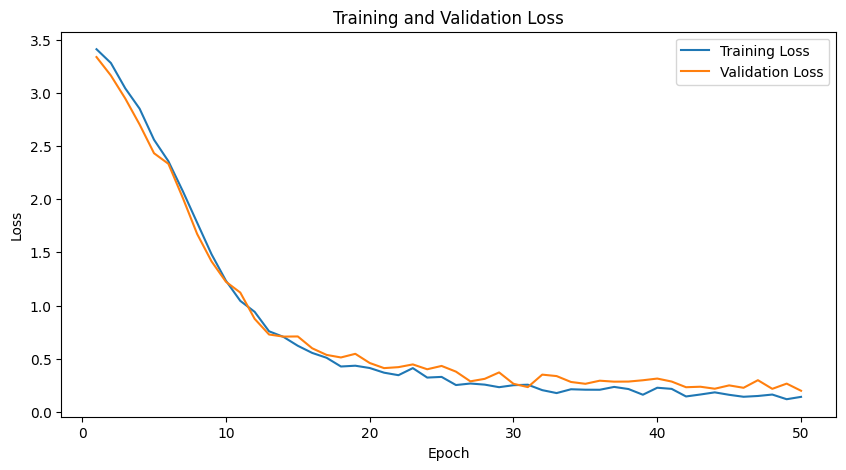

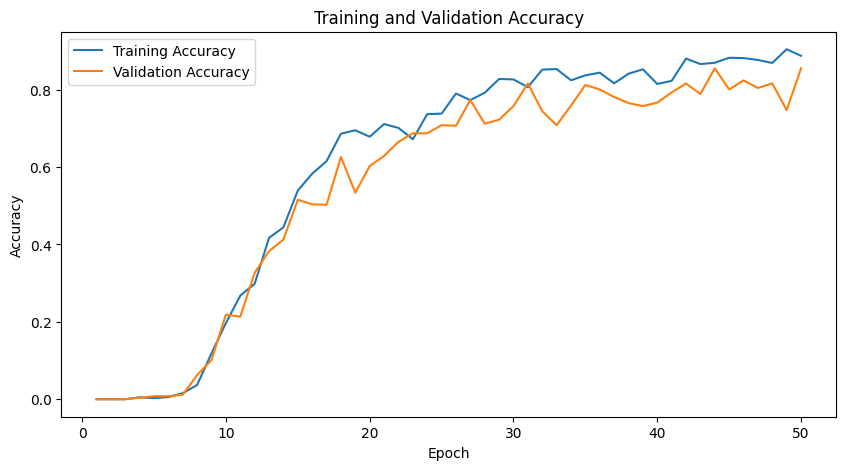

In [12]:
from matplotlib import pyplot as plt

# Plot the loss of the model during training for both training set and validation set.
epochs = list(range(1, len(history_basic) + 1))

loss_train = [h["loss_train"] for h in history_basic]
loss_vali  = [h["loss_vali"] for h in history_basic]

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_train, label="Training Loss")
plt.plot(epochs, loss_vali, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Plot the accuracy of the model during training for both training set and validation set.
acc_train = [h["acc_train"] for h in history_basic]
acc_vali  = [h["acc_vali"] for h in history_basic]

plt.figure(figsize=(10, 5))
plt.plot(epochs, acc_train, label="Training Accuracy")
plt.plot(epochs, acc_vali, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

Next, we evaluate our model end-to-end on the test set. Like training and validation set, we transform test set CAPTCHA images through data augmentation. We then predict the characters for these images and compare the predictions with ground truth. Similar to lab 3, we compute the accuracy of our model and show samples of correct and incorrect predictions:

In [13]:
from torch.utils.data import DataLoader
from tqdm import tqdm

def _prep_images_for_display(img_list):
    prepped = []
    for img in img_list:
        arr = img.detach().cpu().numpy() if hasattr(img, "detach") else np.asarray(img)
        if arr.ndim == 3 and arr.shape[0] == 1:  # (1, H, W) -> (H, W)
            arr = arr[0]
        elif arr.ndim == 3 and arr.shape[-1] == 1:  # (H, W, 1) -> (H, W)
            arr = arr[..., 0]
        prepped.append(arr)
    return prepped

def evaluate_model(model, le, dataset_eval, batch_size=32, n_epochs=5, n_display_samples=10, device=None):
    # Detect device from model parameters if not provided
    device = device or next(iter(model.parameters())).device

    ## [ TODO ]
    # Create evaluation data loader from `dataset_eval`
    # (Note: set the batch size)
    loader_eval = DataLoader(dataset_eval, batch_size=batch_size, shuffle=False)

    # Number of test samples and correct predictions
    n_test = n_correct = 0
    # Correct and incorrect samples
    correct_samples = []
    incorrect_samples = []

    # Put model in validation mode
    model.eval()

    for i in range(n_epochs):
        # In every epoch, do training first ...
        print(f"Starting evaluation epoch {i+1}/{n_epochs} ...")
        for images_batch, texts_batch in tqdm(loader_eval):
            # Make a copy of images batch on target PyTorch device, while keeping original batch on CPU
            images_batch_device = images_batch.to(device)

            ## [ TODO ]
            # 1) Predict characters with neural network model
            outputs = model(images_batch_device)
            # 2) Flatten and move predictions to CPU
            outputs = outputs.reshape(-1, outputs.size(-1)).cpu()
            # 3) Decode predicted class indices back to characters using `LabelEncoder.inverse_transform`
            preds = le.inverse_transform(outputs.argmax(dim=1).numpy())
            # 4) Group every 4 characters together to form predicted CAPTCHAs
            preds = hw2_util.group_every(preds, 4)
            # 5) For each CAPTCHA, its prediction and actual text:
            #    - Update number of correct predictions
            #    - Collect `n_display_samples` correct samples of tuple (image, prediction) for review
            #    - Collect `n_display_samples` incorrect samples of tuple (image, prediction, actual) for review
            #      (Caution: DO NOT print ALL correct / incorrect images; this is slow and the output will be messy!)
            for img, pred, actual in zip(images_batch, preds, texts_batch):
                n_test += 1
                pred_str = "".join(map(str, pred))

                if pred_str == actual:
                    n_correct += 1
                    if len(correct_samples) < n_display_samples:
                        correct_samples.append((img, actual))
                else:
                    if len(incorrect_samples) < n_display_samples:
                        incorrect_samples.append((img, pred_str, actual))

            

        # Report loss and metrics
        print(f"Ending evaluation of epoch {i+1}/{n_epochs} ...")

    # Put model back in training mode
    model.train()

    # Show statistics
    print()
    print("# of test CAPTCHAs:", n_test)
    print("# correctly recognized:", n_correct)
    print("Accuracy:", n_correct/n_test, "\n")

    assert len(correct_samples)<=n_display_samples, \
        f"you should only display {n_display_samples} correct samples as examples!"
    assert len(incorrect_samples)<=n_display_samples, \
        f"you should only display {n_display_samples} incorrect samples as examples!"

    # Show all correct predictions (guard empty list)
    if correct_samples:
        imgs_raw, actuals = hw2_util.unzip(correct_samples)
        imgs = _prep_images_for_display(imgs_raw)
        hw2_util.print_images(
            imgs,
            texts=[f"Correct: {actual}" for actual in actuals],
            n_rows=2
        )
    else:
        print("No correct samples to display.")

    # Show all incorrect predictions (guard empty list)
    if incorrect_samples:
        imgs_raw, preds_list, actuals = hw2_util.unzip(incorrect_samples)
        imgs = _prep_images_for_display(imgs_raw)
        hw2_util.print_images(
            imgs,
            texts=[f"Prediction: {pred}\nActual: {actual}" for pred, actual in zip(preds_list, actuals)],
            n_rows=2,
            fig_size=(20, 6),
            text_center=(0.5, -0.25)
        )
    else:
        print("No incorrect samples to display.")

Now we run the evaluation process on the basic model:

Starting evaluation epoch 1/5 ...


100%|██████████| 8/8 [00:00<00:00, 156.86it/s]


Ending evaluation of epoch 1/5 ...
Starting evaluation epoch 2/5 ...


100%|██████████| 8/8 [00:00<00:00, 170.21it/s]


Ending evaluation of epoch 2/5 ...
Starting evaluation epoch 3/5 ...


100%|██████████| 8/8 [00:00<00:00, 159.37it/s]


Ending evaluation of epoch 3/5 ...
Starting evaluation epoch 4/5 ...


100%|██████████| 8/8 [00:00<00:00, 159.55it/s]


Ending evaluation of epoch 4/5 ...
Starting evaluation epoch 5/5 ...


100%|██████████| 8/8 [00:00<00:00, 152.25it/s]


Ending evaluation of epoch 5/5 ...

# of test CAPTCHAs: 1140
# correctly recognized: 932
Accuracy: 0.8175438596491228 

Figure(2000x500)
Figure(2000x600)


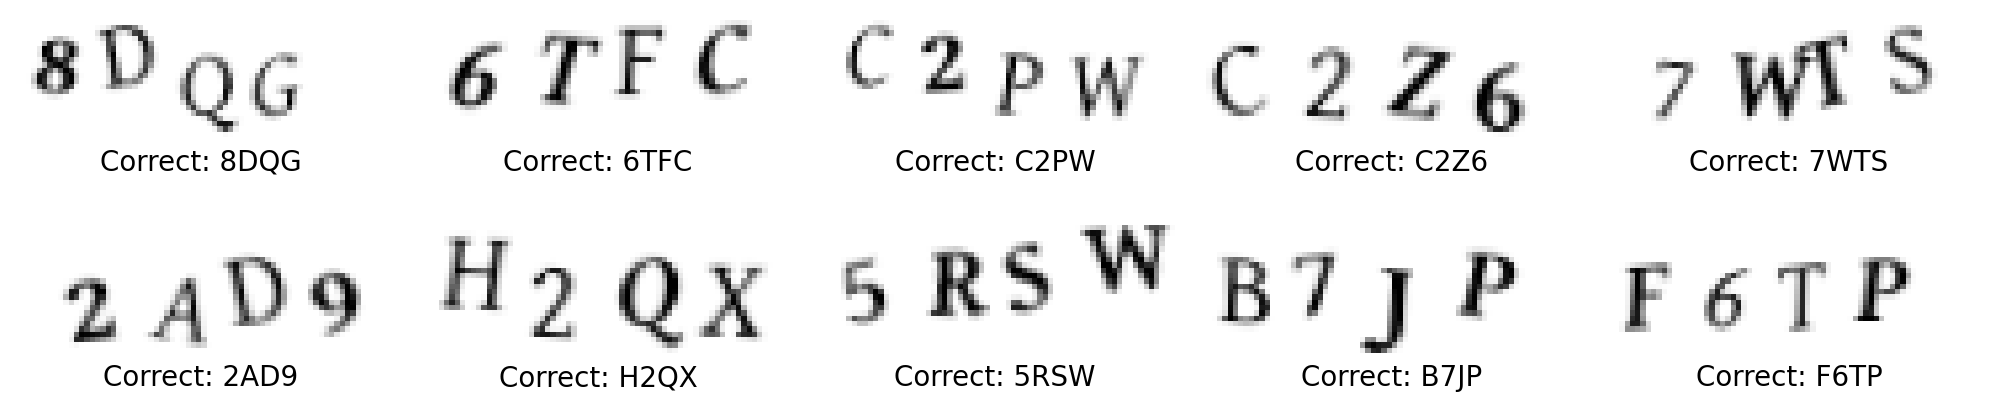

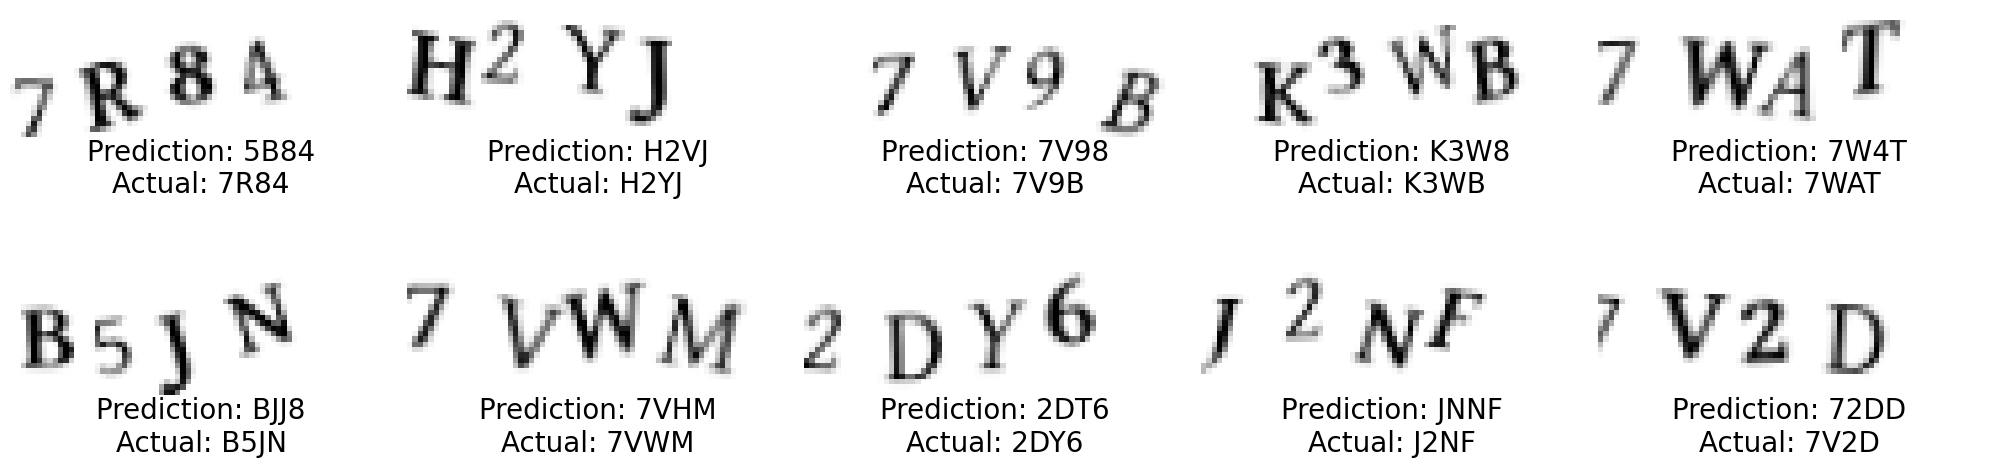

In [14]:
# Build evaluation dataset
dataset_eval = CAPTCHADataset(captcha_images_test, captcha_texts_test, captcha_transform)

# Evaluate the basic model
evaluate_model(model_basic, le, dataset_eval)

## Questions

1. What is the purpose and benefits of data augmentation?


Data augmentation artificially enlarges the training set using label-preserving transformations to improve robustness and reduce overfitting. It increases effective data diversity and acts as a regularizer, improving generalization without collecting new data.

2. What is the purpose of 1*1 convolution kernel?

A 1×1 convolution mixes information across channels at each spatial location without changing spatial dimensions. It is commonly used to adjust channel depth efficiently and build bottleneck structures.

3. What is the purpose of dropout? Does it work on improving the convergence of training or on generalization? Give some reasons to support your idea.

Dropout randomly deactivates neurons during training to prevent co-adaptation and reduce overfitting. It primarily improves generalization rather than convergence, acting as a form of regularization.


4. What is the purpose of batch normalization? Does it work on improving the convergence of training or on generalization? Give some reasons to support your idea.

Batch normalization stabilizes training by normalizing activations within each mini-batch, allowing higher learning rates and faster convergence. It mainly improves optimization but can also provide a mild regularization effect.

## Improvements (Optional; Not Graded)

Like homework 1, **you can optionally choose to work on two improvements to the neural network model**, and see if these modifications help with the accuracy. Please note that we won't grade your solutions for these questions, but we may give you feedbacks should you choose to complete them. We also encourage you to **reuse previous code and functions** as much as possible, and avoid repeating identicial code from previous part of this homework.

***

   Neural network models are susceptible to over-fitting problems due to their huge amount of free parameters. When neural network model overfits, it performs extremely well on the training set, but can easily fail when new samples are added. There are three possible approaches to mitigate the over-fitting issue:

  * Adding regularization (L1 and/or L2) to parameters of each linear or convolution layer.
  * Adding dropout layers (`torch.nn.Dropout`) to the model.
  * Adding batch normalization layers (`torch.nn.BatchNorm2d`) to the model.
  
Try one or a few of these approaches and compare their performance with the original model. Complete the following tasks by adding code and text cells  above and compare their performance with the original model. Complete the following tasks by adding code and text cells below:
  
  * Specify your choice of approaches and the details for each approach:
    - For regularization, this is the type of regularization and regularization factor for each convolution and linear layer.
    - For dropout layers, specify the number, position and dropout rate of all dropout layers.
    - For batch normalization layers, specify the number and position of all batch normalization layers.
  * Plot the loss and accuracy for both training and validation set. Think about what curves to put on the same plot.
    - One idea is to put the same metric of all four models (basic model and three improvement models) for the same set (e.g. training set) on the same plot. In this case, you will get four plots in the end.
    - You don't need to include plots as images in the notebook. Instead, just provide the code that can plot these curves.
  * Finally, report the accuracy of all three improvement models on the test set.

### Chosen improvement variants

- **L2 regularization (weight decay):** keep architecture but train with weight decay `1e-4` to penalize large weights.
- **Dropout:** insert `Dropout(p=0.3)` after each convolution block and before the final 1×1 conv to reduce co-adaptation.
- **Batch normalization:** add `BatchNorm2d` after each convolution to stabilize activations. No dropout here to isolate the effect.

We reuse the same data splits, transforms, `CAPTCHADataset`, and `train_model` to keep comparisons fair.

In [15]:
from copy import deepcopy
from torch import nn

# Builders for improved models

def build_model_dropout(n_classes, p=0.3):
    return nn.Sequential(
        nn.Conv2d(1, 10, kernel_size=5, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(p),

        nn.Conv2d(10, 40, kernel_size=5, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(p),

        nn.Conv2d(40, 100, kernel_size=5, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(p),

        nn.Conv2d(100, 800, kernel_size=(3, 3), stride=(1, 2)),
        nn.ReLU(),
        nn.Dropout(p),

        nn.Conv2d(800, n_classes, kernel_size=(1, 1)),
        nn.Flatten(start_dim=2),
        Transpose(1, 2)
    )


def build_model_batchnorm(n_classes):
    return nn.Sequential(
        nn.Conv2d(1, 10, kernel_size=5, padding=2),
        nn.BatchNorm2d(10),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(10, 40, kernel_size=5, padding=2),
        nn.BatchNorm2d(40),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(40, 100, kernel_size=5, padding=2),
        nn.BatchNorm2d(100),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(100, 800, kernel_size=(3, 3), stride=(1, 2)),
        nn.BatchNorm2d(800),
        nn.ReLU(),

        nn.Conv2d(800, n_classes, kernel_size=(1, 1)),
        nn.Flatten(start_dim=2),
        Transpose(1, 2)
    )


def clone_dataset(dataset):
    """Lightweight copy to avoid accidental mutation of transforms/state."""
    return CAPTCHADataset(dataset.captcha_images, dataset.texts_features, dataset.captcha_transform)


In [16]:
# Train improved models (adjust epochs/batch_size if runtime is long)
batch_size_improved = 32
n_epochs_improved = 50

# L2 (weight decay) model uses same architecture as basic
model_l2 = build_model(n_classes).to(torch_device)
optim_l2 = AdamW(model_l2.parameters(), lr=0.001, weight_decay=1e-4)
history_l2 = train_model(model_l2, optim_l2,
                         clone_dataset(dataset_train), clone_dataset(dataset_vali),
                         batch_size=batch_size_improved, n_epochs=n_epochs_improved, device=torch_device)

dropout_rate = 0.3
model_dropout = build_model_dropout(n_classes, p=dropout_rate).to(torch_device)
optim_dropout = AdamW(model_dropout.parameters(), lr=0.001)
history_dropout = train_model(model_dropout, optim_dropout,
                              clone_dataset(dataset_train), clone_dataset(dataset_vali),
                              batch_size=batch_size_improved, n_epochs=n_epochs_improved, device=torch_device)

model_bn = build_model_batchnorm(n_classes).to(torch_device)
optim_bn = AdamW(model_bn.parameters(), lr=0.001)
history_bn = train_model(model_bn, optim_bn,
                         clone_dataset(dataset_train), clone_dataset(dataset_vali),
                         batch_size=batch_size_improved, n_epochs=n_epochs_improved, device=torch_device)


Starting training ...
Starting training epoch 1/50 ...


100%|██████████| 22/22 [00:00<00:00, 106.28it/s]


Ending training of epoch 1/50: loss: 3.418131113052368, accuracy: 0.0
Starting validation epoch 1/50 ...


100%|██████████| 8/8 [00:00<00:00, 163.26it/s]


Ending validation of epoch 1/50: loss: 3.3626272678375244, accuracy: 0.0
Starting training epoch 2/50 ...


100%|██████████| 22/22 [00:00<00:00, 105.89it/s]


Ending training of epoch 2/50: loss: 3.3374898433685303, accuracy: 0.0
Starting validation epoch 2/50 ...


100%|██████████| 8/8 [00:00<00:00, 170.21it/s]


Ending validation of epoch 2/50: loss: 3.294921398162842, accuracy: 0.0
Starting training epoch 3/50 ...


100%|██████████| 22/22 [00:00<00:00, 94.90it/s]


Ending training of epoch 3/50: loss: 3.257582902908325, accuracy: 0.0
Starting validation epoch 3/50 ...


100%|██████████| 8/8 [00:00<00:00, 170.23it/s]


Ending validation of epoch 3/50: loss: 3.1955461502075195, accuracy: 0.0
Starting training epoch 4/50 ...


100%|██████████| 22/22 [00:00<00:00, 110.00it/s]


Ending training of epoch 4/50: loss: 3.0719404220581055, accuracy: 0.0
Starting validation epoch 4/50 ...


100%|██████████| 8/8 [00:00<00:00, 163.31it/s]


Ending validation of epoch 4/50: loss: 2.9210057258605957, accuracy: 0.0
Starting training epoch 5/50 ...


100%|██████████| 22/22 [00:00<00:00, 107.84it/s]


Ending training of epoch 5/50: loss: 2.857133150100708, accuracy: 0.0
Starting validation epoch 5/50 ...


100%|██████████| 8/8 [00:00<00:00, 177.78it/s]


Ending validation of epoch 5/50: loss: 2.8340535163879395, accuracy: 0.0
Starting training epoch 6/50 ...


100%|██████████| 22/22 [00:00<00:00, 107.32it/s]


Ending training of epoch 6/50: loss: 2.5689661502838135, accuracy: 0.0014204545877873898
Starting validation epoch 6/50 ...


100%|██████████| 8/8 [00:00<00:00, 177.78it/s]


Ending validation of epoch 6/50: loss: 2.4106974601745605, accuracy: 0.0078125
Starting training epoch 7/50 ...


100%|██████████| 22/22 [00:00<00:00, 108.34it/s]


Ending training of epoch 7/50: loss: 2.1310901641845703, accuracy: 0.015625
Starting validation epoch 7/50 ...


100%|██████████| 8/8 [00:00<00:00, 163.43it/s]


Ending validation of epoch 7/50: loss: 1.865142822265625, accuracy: 0.05078125
Starting training epoch 8/50 ...


100%|██████████| 22/22 [00:00<00:00, 112.24it/s]


Ending training of epoch 8/50: loss: 1.6946685314178467, accuracy: 0.06833964586257935
Starting validation epoch 8/50 ...


100%|██████████| 8/8 [00:00<00:00, 170.21it/s]


Ending validation of epoch 8/50: loss: 1.4321826696395874, accuracy: 0.1236979216337204
Starting training epoch 9/50 ...


100%|██████████| 22/22 [00:00<00:00, 107.32it/s]


Ending training of epoch 9/50: loss: 1.4603568315505981, accuracy: 0.12089646607637405
Starting validation epoch 9/50 ...


100%|██████████| 8/8 [00:00<00:00, 170.21it/s]


Ending validation of epoch 9/50: loss: 1.268892765045166, accuracy: 0.13671875
Starting training epoch 10/50 ...


100%|██████████| 22/22 [00:00<00:00, 107.84it/s]


Ending training of epoch 10/50: loss: 1.181890606880188, accuracy: 0.20675505697727203
Starting validation epoch 10/50 ...


100%|██████████| 8/8 [00:00<00:00, 166.66it/s]


Ending validation of epoch 10/50: loss: 1.1275439262390137, accuracy: 0.2526041567325592
Starting training epoch 11/50 ...


100%|██████████| 22/22 [00:00<00:00, 104.76it/s]


Ending training of epoch 11/50: loss: 1.0045853853225708, accuracy: 0.29703283309936523
Starting validation epoch 11/50 ...


100%|██████████| 8/8 [00:00<00:00, 142.86it/s]


Ending validation of epoch 11/50: loss: 0.8861921429634094, accuracy: 0.3268229067325592
Starting training epoch 12/50 ...


100%|██████████| 22/22 [00:00<00:00, 112.04it/s]


Ending training of epoch 12/50: loss: 0.8274761438369751, accuracy: 0.3958333134651184
Starting validation epoch 12/50 ...


100%|██████████| 8/8 [00:00<00:00, 152.87it/s]


Ending validation of epoch 12/50: loss: 0.837638258934021, accuracy: 0.4921875
Starting training epoch 13/50 ...


100%|██████████| 22/22 [00:00<00:00, 104.63it/s]


Ending training of epoch 13/50: loss: 0.7281385064125061, accuracy: 0.47553661465644836
Starting validation epoch 13/50 ...


100%|██████████| 8/8 [00:00<00:00, 181.82it/s]


Ending validation of epoch 13/50: loss: 0.6495239734649658, accuracy: 0.5143229365348816
Starting training epoch 14/50 ...


100%|██████████| 22/22 [00:00<00:00, 106.80it/s]


Ending training of epoch 14/50: loss: 0.64560467004776, accuracy: 0.5506628751754761
Starting validation epoch 14/50 ...


100%|██████████| 8/8 [00:00<00:00, 160.00it/s]


Ending validation of epoch 14/50: loss: 0.6366670727729797, accuracy: 0.5481770634651184
Starting training epoch 15/50 ...


100%|██████████| 22/22 [00:00<00:00, 108.37it/s]


Ending training of epoch 15/50: loss: 0.6604234576225281, accuracy: 0.5246212482452393
Starting validation epoch 15/50 ...


100%|██████████| 8/8 [00:00<00:00, 181.83it/s]


Ending validation of epoch 15/50: loss: 0.5667261481285095, accuracy: 0.5221354365348816
Starting training epoch 16/50 ...


100%|██████████| 22/22 [00:00<00:00, 106.62it/s]


Ending training of epoch 16/50: loss: 0.5413581132888794, accuracy: 0.5928030610084534
Starting validation epoch 16/50 ...


100%|██████████| 8/8 [00:00<00:00, 166.66it/s]


Ending validation of epoch 16/50: loss: 0.5323278903961182, accuracy: 0.50390625
Starting training epoch 17/50 ...


100%|██████████| 22/22 [00:00<00:00, 102.33it/s]


Ending training of epoch 17/50: loss: 0.4971364736557007, accuracy: 0.6617739796638489
Starting validation epoch 17/50 ...


100%|██████████| 8/8 [00:00<00:00, 177.78it/s]


Ending validation of epoch 17/50: loss: 0.41836830973625183, accuracy: 0.6809895634651184
Starting training epoch 18/50 ...


100%|██████████| 22/22 [00:00<00:00, 105.26it/s]


Ending training of epoch 18/50: loss: 0.5061019062995911, accuracy: 0.6246843338012695
Starting validation epoch 18/50 ...


100%|██████████| 8/8 [00:00<00:00, 145.46it/s]


Ending validation of epoch 18/50: loss: 0.3736896514892578, accuracy: 0.6953125
Starting training epoch 19/50 ...


100%|██████████| 22/22 [00:00<00:00, 97.34it/s]


Ending training of epoch 19/50: loss: 0.5052806735038757, accuracy: 0.6695075631141663
Starting validation epoch 19/50 ...


100%|██████████| 8/8 [00:00<00:00, 156.86it/s]


Ending validation of epoch 19/50: loss: 0.4211783707141876, accuracy: 0.6966145634651184
Starting training epoch 20/50 ...


100%|██████████| 22/22 [00:00<00:00, 103.77it/s]


Ending training of epoch 20/50: loss: 0.33741122484207153, accuracy: 0.7626262903213501
Starting validation epoch 20/50 ...


100%|██████████| 8/8 [00:00<00:00, 156.86it/s]


Ending validation of epoch 20/50: loss: 0.39552778005599976, accuracy: 0.7421875
Starting training epoch 21/50 ...


100%|██████████| 22/22 [00:00<00:00, 102.75it/s]


Ending training of epoch 21/50: loss: 0.3528931736946106, accuracy: 0.7419507503509521
Starting validation epoch 21/50 ...


100%|██████████| 8/8 [00:00<00:00, 135.59it/s]


Ending validation of epoch 21/50: loss: 0.3696068525314331, accuracy: 0.703125
Starting training epoch 22/50 ...


100%|██████████| 22/22 [00:00<00:00, 102.52it/s]


Ending training of epoch 22/50: loss: 0.36023885011672974, accuracy: 0.7370581030845642
Starting validation epoch 22/50 ...


100%|██████████| 8/8 [00:00<00:00, 159.98it/s]


Ending validation of epoch 22/50: loss: 0.41829395294189453, accuracy: 0.6848958134651184
Starting training epoch 23/50 ...


100%|██████████| 22/22 [00:00<00:00, 99.16it/s]


Ending training of epoch 23/50: loss: 0.3865191638469696, accuracy: 0.7477903962135315
Starting validation epoch 23/50 ...


100%|██████████| 8/8 [00:00<00:00, 157.48it/s]


Ending validation of epoch 23/50: loss: 0.4172283709049225, accuracy: 0.7317708134651184
Starting training epoch 24/50 ...


100%|██████████| 22/22 [00:00<00:00, 106.28it/s]


Ending training of epoch 24/50: loss: 0.3609620928764343, accuracy: 0.7476325631141663
Starting validation epoch 24/50 ...


100%|██████████| 8/8 [00:00<00:00, 140.30it/s]


Ending validation of epoch 24/50: loss: 0.3213651776313782, accuracy: 0.7395833134651184
Starting training epoch 25/50 ...


100%|██████████| 22/22 [00:00<00:00, 109.24it/s]


Ending training of epoch 25/50: loss: 0.29317840933799744, accuracy: 0.788194477558136
Starting validation epoch 25/50 ...


100%|██████████| 8/8 [00:00<00:00, 150.93it/s]


Ending validation of epoch 25/50: loss: 0.32151955366134644, accuracy: 0.6783854365348816
Starting training epoch 26/50 ...


100%|██████████| 22/22 [00:00<00:00, 98.66it/s]


Ending training of epoch 26/50: loss: 0.3325492739677429, accuracy: 0.7826704382896423
Starting validation epoch 26/50 ...


100%|██████████| 8/8 [00:00<00:00, 152.51it/s]


Ending validation of epoch 26/50: loss: 0.2556861937046051, accuracy: 0.7708333134651184
Starting training epoch 27/50 ...


100%|██████████| 22/22 [00:00<00:00, 107.38it/s]


Ending training of epoch 27/50: loss: 0.23658670485019684, accuracy: 0.8352272510528564
Starting validation epoch 27/50 ...


100%|██████████| 8/8 [00:00<00:00, 163.26it/s]


Ending validation of epoch 27/50: loss: 0.39790093898773193, accuracy: 0.6575520634651184
Starting training epoch 28/50 ...


100%|██████████| 22/22 [00:00<00:00, 103.33it/s]


Ending training of epoch 28/50: loss: 0.2452414631843567, accuracy: 0.8088699579238892
Starting validation epoch 28/50 ...


100%|██████████| 8/8 [00:00<00:00, 163.28it/s]


Ending validation of epoch 28/50: loss: 0.3173079788684845, accuracy: 0.7057291865348816
Starting training epoch 29/50 ...


100%|██████████| 22/22 [00:00<00:00, 110.33it/s]


Ending training of epoch 29/50: loss: 0.22710123658180237, accuracy: 0.8372790813446045
Starting validation epoch 29/50 ...


100%|██████████| 8/8 [00:00<00:00, 177.78it/s]


Ending validation of epoch 29/50: loss: 0.3275233209133148, accuracy: 0.7057291865348816
Starting training epoch 30/50 ...


100%|██████████| 22/22 [00:00<00:00, 115.79it/s]


Ending training of epoch 30/50: loss: 0.2614970803260803, accuracy: 0.814393937587738
Starting validation epoch 30/50 ...


100%|██████████| 8/8 [00:00<00:00, 163.27it/s]


Ending validation of epoch 30/50: loss: 0.30842849612236023, accuracy: 0.7552083134651184
Starting training epoch 31/50 ...


100%|██████████| 22/22 [00:00<00:00, 102.79it/s]


Ending training of epoch 31/50: loss: 0.20262393355369568, accuracy: 0.8238636255264282
Starting validation epoch 31/50 ...


100%|██████████| 8/8 [00:00<00:00, 166.99it/s]


Ending validation of epoch 31/50: loss: 0.26095089316368103, accuracy: 0.80859375
Starting training epoch 32/50 ...


100%|██████████| 22/22 [00:00<00:00, 105.58it/s]


Ending training of epoch 32/50: loss: 0.22859469056129456, accuracy: 0.8486427068710327
Starting validation epoch 32/50 ...


100%|██████████| 8/8 [00:00<00:00, 169.03it/s]


Ending validation of epoch 32/50: loss: 0.30996161699295044, accuracy: 0.7669270634651184
Starting training epoch 33/50 ...


100%|██████████| 22/22 [00:00<00:00, 105.77it/s]


Ending training of epoch 33/50: loss: 0.22934986650943756, accuracy: 0.8322286009788513
Starting validation epoch 33/50 ...


100%|██████████| 8/8 [00:00<00:00, 173.92it/s]


Ending validation of epoch 33/50: loss: 0.3859449326992035, accuracy: 0.6927083134651184
Starting training epoch 34/50 ...


100%|██████████| 22/22 [00:00<00:00, 107.82it/s]


Ending training of epoch 34/50: loss: 0.2039487212896347, accuracy: 0.8237058520317078
Starting validation epoch 34/50 ...


100%|██████████| 8/8 [00:00<00:00, 164.60it/s]


Ending validation of epoch 34/50: loss: 0.2927021384239197, accuracy: 0.7278645634651184
Starting training epoch 35/50 ...


100%|██████████| 22/22 [00:00<00:00, 105.08it/s]


Ending training of epoch 35/50: loss: 0.17480620741844177, accuracy: 0.8571653962135315
Starting validation epoch 35/50 ...


100%|██████████| 8/8 [00:00<00:00, 163.99it/s]


Ending validation of epoch 35/50: loss: 0.23515723645687103, accuracy: 0.85546875
Starting training epoch 36/50 ...


100%|██████████| 22/22 [00:00<00:00, 107.04it/s]


Ending training of epoch 36/50: loss: 0.191659078001976, accuracy: 0.8429608941078186
Starting validation epoch 36/50 ...


100%|██████████| 8/8 [00:00<00:00, 161.05it/s]


Ending validation of epoch 36/50: loss: 0.2404015064239502, accuracy: 0.7981770634651184
Starting training epoch 37/50 ...


100%|██████████| 22/22 [00:00<00:00, 105.41it/s]


Ending training of epoch 37/50: loss: 0.2076193243265152, accuracy: 0.8386995196342468
Starting validation epoch 37/50 ...


100%|██████████| 8/8 [00:00<00:00, 162.62it/s]


Ending validation of epoch 37/50: loss: 0.21862360835075378, accuracy: 0.84375
Starting training epoch 38/50 ...


100%|██████████| 22/22 [00:00<00:00, 110.85it/s]


Ending training of epoch 38/50: loss: 0.17759329080581665, accuracy: 0.8486427068710327
Starting validation epoch 38/50 ...


100%|██████████| 8/8 [00:00<00:00, 177.78it/s]


Ending validation of epoch 38/50: loss: 0.3027033805847168, accuracy: 0.7591145634651184
Starting training epoch 39/50 ...


100%|██████████| 22/22 [00:00<00:00, 113.15it/s]


Ending training of epoch 39/50: loss: 0.22118033468723297, accuracy: 0.8364899158477783
Starting validation epoch 39/50 ...


100%|██████████| 8/8 [00:00<00:00, 150.95it/s]


Ending validation of epoch 39/50: loss: 0.2429388165473938, accuracy: 0.82421875
Starting training epoch 40/50 ...


100%|██████████| 22/22 [00:00<00:00, 109.45it/s]


Ending training of epoch 40/50: loss: 0.19916845858097076, accuracy: 0.8415403962135315
Starting validation epoch 40/50 ...


100%|██████████| 8/8 [00:00<00:00, 160.00it/s]


Ending validation of epoch 40/50: loss: 0.17386658489704132, accuracy: 0.85546875
Starting training epoch 41/50 ...


100%|██████████| 22/22 [00:00<00:00, 109.45it/s]


Ending training of epoch 41/50: loss: 0.1760760396718979, accuracy: 0.8671085834503174
Starting validation epoch 41/50 ...


100%|██████████| 8/8 [00:00<00:00, 170.22it/s]


Ending validation of epoch 41/50: loss: 0.22317993640899658, accuracy: 0.796875
Starting training epoch 42/50 ...


100%|██████████| 22/22 [00:00<00:00, 108.37it/s]


Ending training of epoch 42/50: loss: 0.13578535616397858, accuracy: 0.8821022510528564
Starting validation epoch 42/50 ...


100%|██████████| 8/8 [00:00<00:00, 164.40it/s]


Ending validation of epoch 42/50: loss: 0.2012639194726944, accuracy: 0.8177083134651184
Starting training epoch 43/50 ...


100%|██████████| 22/22 [00:00<00:00, 109.65it/s]


Ending training of epoch 43/50: loss: 0.12231863290071487, accuracy: 0.8961490392684937
Starting validation epoch 43/50 ...


100%|██████████| 8/8 [00:00<00:00, 162.04it/s]


Ending validation of epoch 43/50: loss: 0.20282390713691711, accuracy: 0.8515625
Starting training epoch 44/50 ...


100%|██████████| 22/22 [00:00<00:00, 111.77it/s]


Ending training of epoch 44/50: loss: 0.15655669569969177, accuracy: 0.8798927068710327
Starting validation epoch 44/50 ...


100%|██████████| 8/8 [00:00<00:00, 163.61it/s]


Ending validation of epoch 44/50: loss: 0.24031661450862885, accuracy: 0.78125
Starting training epoch 45/50 ...


100%|██████████| 22/22 [00:00<00:00, 111.82it/s]


Ending training of epoch 45/50: loss: 0.16571475565433502, accuracy: 0.8678977489471436
Starting validation epoch 45/50 ...


100%|██████████| 8/8 [00:00<00:00, 133.80it/s]


Ending validation of epoch 45/50: loss: 0.20070935785770416, accuracy: 0.84765625
Starting training epoch 46/50 ...


100%|██████████| 22/22 [00:00<00:00, 105.64it/s]


Ending training of epoch 46/50: loss: 0.14183105528354645, accuracy: 0.8805240392684937
Starting validation epoch 46/50 ...


100%|██████████| 8/8 [00:00<00:00, 147.34it/s]


Ending validation of epoch 46/50: loss: 0.21436266601085663, accuracy: 0.84765625
Starting training epoch 47/50 ...


100%|██████████| 22/22 [00:00<00:00, 107.11it/s]


Ending training of epoch 47/50: loss: 0.16036356985569, accuracy: 0.881313145160675
Starting validation epoch 47/50 ...


100%|██████████| 8/8 [00:00<00:00, 177.74it/s]


Ending validation of epoch 47/50: loss: 0.22340887784957886, accuracy: 0.8020833134651184
Starting training epoch 48/50 ...


100%|██████████| 22/22 [00:00<00:00, 105.22it/s]


Ending training of epoch 48/50: loss: 0.1319359689950943, accuracy: 0.8827335834503174
Starting validation epoch 48/50 ...


100%|██████████| 8/8 [00:00<00:00, 170.18it/s]


Ending validation of epoch 48/50: loss: 0.23228392004966736, accuracy: 0.7981770634651184
Starting training epoch 49/50 ...


100%|██████████| 22/22 [00:00<00:00, 108.37it/s]


Ending training of epoch 49/50: loss: 0.14731837809085846, accuracy: 0.8821022510528564
Starting validation epoch 49/50 ...


100%|██████████| 8/8 [00:00<00:00, 170.22it/s]


Ending validation of epoch 49/50: loss: 0.28073301911354065, accuracy: 0.8125
Starting training epoch 50/50 ...


100%|██████████| 22/22 [00:00<00:00, 111.11it/s]


Ending training of epoch 50/50: loss: 0.12203839421272278, accuracy: 0.8821022510528564
Starting validation epoch 50/50 ...


100%|██████████| 8/8 [00:00<00:00, 166.70it/s]


Ending validation of epoch 50/50: loss: 0.2101205736398697, accuracy: 0.8515625
Starting training ...
Starting training epoch 1/50 ...


100%|██████████| 22/22 [00:00<00:00, 105.77it/s]


Ending training of epoch 1/50: loss: 3.4266464710235596, accuracy: 0.0
Starting validation epoch 1/50 ...


100%|██████████| 8/8 [00:00<00:00, 170.21it/s]


Ending validation of epoch 1/50: loss: 3.3853681087493896, accuracy: 0.0
Starting training epoch 2/50 ...


100%|██████████| 22/22 [00:00<00:00, 109.04it/s]


Ending training of epoch 2/50: loss: 3.347060203552246, accuracy: 0.0
Starting validation epoch 2/50 ...


100%|██████████| 8/8 [00:00<00:00, 173.89it/s]


Ending validation of epoch 2/50: loss: 3.3390166759490967, accuracy: 0.0
Starting training epoch 3/50 ...


100%|██████████| 22/22 [00:00<00:00, 111.67it/s]


Ending training of epoch 3/50: loss: 3.2304725646972656, accuracy: 0.0
Starting validation epoch 3/50 ...


100%|██████████| 8/8 [00:00<00:00, 173.89it/s]


Ending validation of epoch 3/50: loss: 3.1599199771881104, accuracy: 0.0
Starting training epoch 4/50 ...


100%|██████████| 22/22 [00:00<00:00, 113.37it/s]


Ending training of epoch 4/50: loss: 3.036933660507202, accuracy: 0.0
Starting validation epoch 4/50 ...


100%|██████████| 8/8 [00:00<00:00, 159.33it/s]


Ending validation of epoch 4/50: loss: 2.8984897136688232, accuracy: 0.0
Starting training epoch 5/50 ...


100%|██████████| 22/22 [00:00<00:00, 105.11it/s]


Ending training of epoch 5/50: loss: 2.877906560897827, accuracy: 0.0014204545877873898
Starting validation epoch 5/50 ...


100%|██████████| 8/8 [00:00<00:00, 163.30it/s]


Ending validation of epoch 5/50: loss: 2.7668728828430176, accuracy: 0.0
Starting training epoch 6/50 ...


100%|██████████| 22/22 [00:00<00:00, 102.91it/s]


Ending training of epoch 6/50: loss: 2.7196919918060303, accuracy: 0.0014204545877873898
Starting validation epoch 6/50 ...


100%|██████████| 8/8 [00:00<00:00, 173.88it/s]


Ending validation of epoch 6/50: loss: 2.5489330291748047, accuracy: 0.0
Starting training epoch 7/50 ...


100%|██████████| 22/22 [00:00<00:00, 106.28it/s]


Ending training of epoch 7/50: loss: 2.5128297805786133, accuracy: 0.0028409091755747795
Starting validation epoch 7/50 ...


100%|██████████| 8/8 [00:00<00:00, 166.64it/s]


Ending validation of epoch 7/50: loss: 2.3815314769744873, accuracy: 0.01171875
Starting training epoch 8/50 ...


100%|██████████| 22/22 [00:00<00:00, 110.34it/s]


Ending training of epoch 8/50: loss: 2.297224521636963, accuracy: 0.011363636702299118
Starting validation epoch 8/50 ...


100%|██████████| 8/8 [00:00<00:00, 158.61it/s]


Ending validation of epoch 8/50: loss: 2.1555168628692627, accuracy: 0.01171875
Starting training epoch 9/50 ...


100%|██████████| 22/22 [00:00<00:00, 108.35it/s]


Ending training of epoch 9/50: loss: 2.08748459815979, accuracy: 0.01278409082442522
Starting validation epoch 9/50 ...


100%|██████████| 8/8 [00:00<00:00, 55.39it/s]


Ending validation of epoch 9/50: loss: 1.7468124628067017, accuracy: 0.046875
Starting training epoch 10/50 ...


100%|██████████| 22/22 [00:01<00:00, 15.65it/s]


Ending training of epoch 10/50: loss: 1.875511646270752, accuracy: 0.03345959633588791
Starting validation epoch 10/50 ...


100%|██████████| 8/8 [00:00<00:00, 20.10it/s]


Ending validation of epoch 10/50: loss: 1.4791884422302246, accuracy: 0.08984375
Starting training epoch 11/50 ...


100%|██████████| 22/22 [00:01<00:00, 12.55it/s]


Ending training of epoch 11/50: loss: 1.7258968353271484, accuracy: 0.05113636329770088
Starting validation epoch 11/50 ...


100%|██████████| 8/8 [00:00<00:00, 22.99it/s]


Ending validation of epoch 11/50: loss: 1.3325953483581543, accuracy: 0.2057291716337204
Starting training epoch 12/50 ...


100%|██████████| 22/22 [00:01<00:00, 16.83it/s]


Ending training of epoch 12/50: loss: 1.4996867179870605, accuracy: 0.06107954680919647
Starting validation epoch 12/50 ...


100%|██████████| 8/8 [00:00<00:00, 23.06it/s]


Ending validation of epoch 12/50: loss: 1.1047770977020264, accuracy: 0.21875
Starting training epoch 13/50 ...


100%|██████████| 22/22 [00:01<00:00, 17.26it/s]


Ending training of epoch 13/50: loss: 1.3698633909225464, accuracy: 0.11016414314508438
Starting validation epoch 13/50 ...


100%|██████████| 8/8 [00:00<00:00, 20.68it/s]


Ending validation of epoch 13/50: loss: 0.9532093405723572, accuracy: 0.3489583432674408
Starting training epoch 14/50 ...


100%|██████████| 22/22 [00:01<00:00, 16.63it/s]


Ending training of epoch 14/50: loss: 1.2522801160812378, accuracy: 0.1649305671453476
Starting validation epoch 14/50 ...


100%|██████████| 8/8 [00:00<00:00, 18.70it/s]


Ending validation of epoch 14/50: loss: 0.8279125690460205, accuracy: 0.3932291567325592
Starting training epoch 15/50 ...


100%|██████████| 22/22 [00:01<00:00, 15.74it/s]


Ending training of epoch 15/50: loss: 1.1464800834655762, accuracy: 0.19760102033615112
Starting validation epoch 15/50 ...


100%|██████████| 8/8 [00:00<00:00, 20.15it/s]


Ending validation of epoch 15/50: loss: 0.8154557347297668, accuracy: 0.47265625
Starting training epoch 16/50 ...


100%|██████████| 22/22 [00:00<00:00, 32.54it/s]


Ending training of epoch 16/50: loss: 0.968291699886322, accuracy: 0.25157830119132996
Starting validation epoch 16/50 ...


100%|██████████| 8/8 [00:00<00:00, 170.19it/s]


Ending validation of epoch 16/50: loss: 0.5868126749992371, accuracy: 0.5052083134651184
Starting training epoch 17/50 ...


100%|██████████| 22/22 [00:00<00:00, 111.68it/s]


Ending training of epoch 17/50: loss: 0.9827907681465149, accuracy: 0.2643623650074005
Starting validation epoch 17/50 ...


100%|██████████| 8/8 [00:00<00:00, 166.63it/s]


Ending validation of epoch 17/50: loss: 0.6931778788566589, accuracy: 0.5065104365348816
Starting training epoch 18/50 ...


100%|██████████| 22/22 [00:00<00:00, 102.80it/s]


Ending training of epoch 18/50: loss: 0.8990229964256287, accuracy: 0.2886679470539093
Starting validation epoch 18/50 ...


100%|██████████| 8/8 [00:00<00:00, 181.79it/s]


Ending validation of epoch 18/50: loss: 0.49312126636505127, accuracy: 0.6640625
Starting training epoch 19/50 ...


100%|██████████| 22/22 [00:00<00:00, 112.82it/s]


Ending training of epoch 19/50: loss: 0.8160280585289001, accuracy: 0.329071968793869
Starting validation epoch 19/50 ...


100%|██████████| 8/8 [00:00<00:00, 170.19it/s]


Ending validation of epoch 19/50: loss: 0.5479198098182678, accuracy: 0.640625
Starting training epoch 20/50 ...


100%|██████████| 22/22 [00:00<00:00, 108.13it/s]


Ending training of epoch 20/50: loss: 0.7964650988578796, accuracy: 0.3723169267177582
Starting validation epoch 20/50 ...


100%|██████████| 8/8 [00:00<00:00, 181.78it/s]


Ending validation of epoch 20/50: loss: 0.49964430928230286, accuracy: 0.625
Starting training epoch 21/50 ...


100%|██████████| 22/22 [00:00<00:00, 102.33it/s]


Ending training of epoch 21/50: loss: 0.813505232334137, accuracy: 0.3723169267177582
Starting validation epoch 21/50 ...


100%|██████████| 8/8 [00:00<00:00, 166.64it/s]


Ending validation of epoch 21/50: loss: 0.4529799818992615, accuracy: 0.6575520634651184
Starting training epoch 22/50 ...


100%|██████████| 22/22 [00:00<00:00, 92.83it/s]


Ending training of epoch 22/50: loss: 0.7623525261878967, accuracy: 0.422821968793869
Starting validation epoch 22/50 ...


100%|██████████| 8/8 [00:00<00:00, 154.83it/s]


Ending validation of epoch 22/50: loss: 0.40572410821914673, accuracy: 0.70703125
Starting training epoch 23/50 ...


100%|██████████| 22/22 [00:00<00:00, 93.81it/s]


Ending training of epoch 23/50: loss: 0.6413055062294006, accuracy: 0.45975378155708313
Starting validation epoch 23/50 ...


100%|██████████| 8/8 [00:00<00:00, 177.75it/s]


Ending validation of epoch 23/50: loss: 0.42314016819000244, accuracy: 0.72265625
Starting training epoch 24/50 ...


100%|██████████| 22/22 [00:00<00:00, 110.00it/s]


Ending training of epoch 24/50: loss: 0.6522656083106995, accuracy: 0.4556502401828766
Starting validation epoch 24/50 ...


100%|██████████| 8/8 [00:00<00:00, 155.92it/s]


Ending validation of epoch 24/50: loss: 0.39661142230033875, accuracy: 0.7005208134651184
Starting training epoch 25/50 ...


100%|██████████| 22/22 [00:00<00:00, 103.08it/s]


Ending training of epoch 25/50: loss: 0.5782821178436279, accuracy: 0.5033144354820251
Starting validation epoch 25/50 ...


100%|██████████| 8/8 [00:00<00:00, 165.25it/s]


Ending validation of epoch 25/50: loss: 0.2656915783882141, accuracy: 0.8046875
Starting training epoch 26/50 ...


100%|██████████| 22/22 [00:00<00:00, 107.63it/s]


Ending training of epoch 26/50: loss: 0.5642403364181519, accuracy: 0.5097853541374207
Starting validation epoch 26/50 ...


100%|██████████| 8/8 [00:00<00:00, 166.67it/s]


Ending validation of epoch 26/50: loss: 0.3088895082473755, accuracy: 0.7421875
Starting training epoch 27/50 ...


100%|██████████| 22/22 [00:00<00:00, 106.74it/s]


Ending training of epoch 27/50: loss: 0.6106704473495483, accuracy: 0.5116792917251587
Starting validation epoch 27/50 ...


100%|██████████| 8/8 [00:00<00:00, 152.14it/s]


Ending validation of epoch 27/50: loss: 0.2799451947212219, accuracy: 0.81640625
Starting training epoch 28/50 ...


100%|██████████| 22/22 [00:00<00:00, 107.84it/s]


Ending training of epoch 28/50: loss: 0.5480523705482483, accuracy: 0.5301452279090881
Starting validation epoch 28/50 ...


100%|██████████| 8/8 [00:00<00:00, 156.86it/s]


Ending validation of epoch 28/50: loss: 0.2903411090373993, accuracy: 0.8125
Starting training epoch 29/50 ...


100%|██████████| 22/22 [00:00<00:00, 102.32it/s]


Ending training of epoch 29/50: loss: 0.5320455431938171, accuracy: 0.5464015007019043
Starting validation epoch 29/50 ...


100%|██████████| 8/8 [00:00<00:00, 137.93it/s]


Ending validation of epoch 29/50: loss: 0.3475978970527649, accuracy: 0.7578125
Starting training epoch 30/50 ...


100%|██████████| 22/22 [00:00<00:00, 89.53it/s]


Ending training of epoch 30/50: loss: 0.4976283013820648, accuracy: 0.595643937587738
Starting validation epoch 30/50 ...


100%|██████████| 8/8 [00:00<00:00, 115.92it/s]


Ending validation of epoch 30/50: loss: 0.3418298661708832, accuracy: 0.7513020634651184
Starting training epoch 31/50 ...


100%|██████████| 22/22 [00:00<00:00, 105.26it/s]


Ending training of epoch 31/50: loss: 0.541534960269928, accuracy: 0.571338415145874
Starting validation epoch 31/50 ...


100%|██████████| 8/8 [00:00<00:00, 156.84it/s]


Ending validation of epoch 31/50: loss: 0.3148595094680786, accuracy: 0.7057291865348816
Starting training epoch 32/50 ...


100%|██████████| 22/22 [00:00<00:00, 104.76it/s]


Ending training of epoch 32/50: loss: 0.4499828517436981, accuracy: 0.6248421669006348
Starting validation epoch 32/50 ...


100%|██████████| 8/8 [00:00<00:00, 163.27it/s]


Ending validation of epoch 32/50: loss: 0.23759716749191284, accuracy: 0.7825520634651184
Starting training epoch 33/50 ...


100%|██████████| 22/22 [00:00<00:00, 109.30it/s]


Ending training of epoch 33/50: loss: 0.43420279026031494, accuracy: 0.6169507503509521
Starting validation epoch 33/50 ...


100%|██████████| 8/8 [00:00<00:00, 153.85it/s]


Ending validation of epoch 33/50: loss: 0.29426664113998413, accuracy: 0.80859375
Starting training epoch 34/50 ...


100%|██████████| 22/22 [00:00<00:00, 101.38it/s]


Ending training of epoch 34/50: loss: 0.500821590423584, accuracy: 0.5883838534355164
Starting validation epoch 34/50 ...


100%|██████████| 8/8 [00:00<00:00, 145.44it/s]


Ending validation of epoch 34/50: loss: 0.26995205879211426, accuracy: 0.8046875
Starting training epoch 35/50 ...


100%|██████████| 22/22 [00:00<00:00, 100.41it/s]


Ending training of epoch 35/50: loss: 0.40058669447898865, accuracy: 0.6455177068710327
Starting validation epoch 35/50 ...


100%|██████████| 8/8 [00:00<00:00, 137.93it/s]


Ending validation of epoch 35/50: loss: 0.26324138045310974, accuracy: 0.7786458134651184
Starting training epoch 36/50 ...


100%|██████████| 22/22 [00:00<00:00, 94.02it/s]


Ending training of epoch 36/50: loss: 0.3969833552837372, accuracy: 0.6467803120613098
Starting validation epoch 36/50 ...


100%|██████████| 8/8 [00:00<00:00, 112.67it/s]


Ending validation of epoch 36/50: loss: 0.20165041089057922, accuracy: 0.84765625
Starting training epoch 37/50 ...


100%|██████████| 22/22 [00:00<00:00, 65.87it/s]


Ending training of epoch 37/50: loss: 0.4186212718486786, accuracy: 0.6175820827484131
Starting validation epoch 37/50 ...


100%|██████████| 8/8 [00:00<00:00, 133.35it/s]


Ending validation of epoch 37/50: loss: 0.21012945473194122, accuracy: 0.8515625
Starting training epoch 38/50 ...


100%|██████████| 22/22 [00:00<00:00, 97.78it/s]


Ending training of epoch 38/50: loss: 0.4396047592163086, accuracy: 0.6234217286109924
Starting validation epoch 38/50 ...


100%|██████████| 8/8 [00:00<00:00, 83.34it/s]


Ending validation of epoch 38/50: loss: 0.361358106136322, accuracy: 0.7513020634651184
Starting training epoch 39/50 ...


100%|██████████| 22/22 [00:00<00:00, 89.18it/s]


Ending training of epoch 39/50: loss: 0.35619720816612244, accuracy: 0.6523042917251587
Starting validation epoch 39/50 ...


100%|██████████| 8/8 [00:00<00:00, 115.95it/s]


Ending validation of epoch 39/50: loss: 0.23143234848976135, accuracy: 0.8203125
Starting training epoch 40/50 ...


100%|██████████| 22/22 [00:00<00:00, 74.07it/s]


Ending training of epoch 40/50: loss: 0.42202404141426086, accuracy: 0.6238952279090881
Starting validation epoch 40/50 ...


100%|██████████| 8/8 [00:00<00:00, 170.19it/s]


Ending validation of epoch 40/50: loss: 0.22829557955265045, accuracy: 0.7981770634651184
Starting training epoch 41/50 ...


100%|██████████| 22/22 [00:00<00:00, 108.37it/s]


Ending training of epoch 41/50: loss: 0.4076167345046997, accuracy: 0.6510416865348816
Starting validation epoch 41/50 ...


100%|██████████| 8/8 [00:00<00:00, 163.24it/s]


Ending validation of epoch 41/50: loss: 0.21321770548820496, accuracy: 0.828125
Starting training epoch 42/50 ...


100%|██████████| 22/22 [00:00<00:00, 98.65it/s] 


Ending training of epoch 42/50: loss: 0.36568009853363037, accuracy: 0.667455792427063
Starting validation epoch 42/50 ...


100%|██████████| 8/8 [00:00<00:00, 166.64it/s]


Ending validation of epoch 42/50: loss: 0.2508530020713806, accuracy: 0.83984375
Starting training epoch 43/50 ...


100%|██████████| 22/22 [00:00<00:00, 103.78it/s]


Ending training of epoch 43/50: loss: 0.32725703716278076, accuracy: 0.6903409361839294
Starting validation epoch 43/50 ...


100%|██████████| 8/8 [00:00<00:00, 160.03it/s]


Ending validation of epoch 43/50: loss: 0.18497802317142487, accuracy: 0.859375
Starting training epoch 44/50 ...


100%|██████████| 22/22 [00:00<00:00, 102.80it/s]


Ending training of epoch 44/50: loss: 0.3608371913433075, accuracy: 0.6916035413742065
Starting validation epoch 44/50 ...


100%|██████████| 8/8 [00:00<00:00, 159.98it/s]


Ending validation of epoch 44/50: loss: 0.15099796652793884, accuracy: 0.8828125
Starting training epoch 45/50 ...


100%|██████████| 22/22 [00:00<00:00, 107.32it/s]


Ending training of epoch 45/50: loss: 0.3161379098892212, accuracy: 0.689393937587738
Starting validation epoch 45/50 ...


100%|██████████| 8/8 [00:00<00:00, 153.85it/s]


Ending validation of epoch 45/50: loss: 0.1908816248178482, accuracy: 0.859375
Starting training epoch 46/50 ...


100%|██████████| 22/22 [00:00<00:00, 97.35it/s]


Ending training of epoch 46/50: loss: 0.3342670202255249, accuracy: 0.6985479593276978
Starting validation epoch 46/50 ...


100%|██████████| 8/8 [00:00<00:00, 142.84it/s]


Ending validation of epoch 46/50: loss: 0.30266574025154114, accuracy: 0.7864583134651184
Starting training epoch 47/50 ...


100%|██████████| 22/22 [00:00<00:00, 105.27it/s]


Ending training of epoch 47/50: loss: 0.3281230926513672, accuracy: 0.7023358941078186
Starting validation epoch 47/50 ...


100%|██████████| 8/8 [00:00<00:00, 159.97it/s]


Ending validation of epoch 47/50: loss: 0.2141522318124771, accuracy: 0.84375
Starting training epoch 48/50 ...


100%|██████████| 22/22 [00:00<00:00, 102.81it/s]


Ending training of epoch 48/50: loss: 0.3115180730819702, accuracy: 0.7271149158477783
Starting validation epoch 48/50 ...


100%|██████████| 8/8 [00:00<00:00, 153.85it/s]


Ending validation of epoch 48/50: loss: 0.22200065851211548, accuracy: 0.8515625
Starting training epoch 49/50 ...


100%|██████████| 22/22 [00:00<00:00, 107.31it/s]


Ending training of epoch 49/50: loss: 0.3234769105911255, accuracy: 0.7028093338012695
Starting validation epoch 49/50 ...


100%|██████████| 8/8 [00:00<00:00, 156.84it/s]


Ending validation of epoch 49/50: loss: 0.17360606789588928, accuracy: 0.8671875
Starting training epoch 50/50 ...


100%|██████████| 22/22 [00:00<00:00, 91.30it/s]


Ending training of epoch 50/50: loss: 0.33109018206596375, accuracy: 0.7192234992980957
Starting validation epoch 50/50 ...


100%|██████████| 8/8 [00:00<00:00, 156.87it/s]


Ending validation of epoch 50/50: loss: 0.1883152574300766, accuracy: 0.84765625
Starting training ...
Starting training epoch 1/50 ...


100%|██████████| 22/22 [00:00<00:00, 96.92it/s]


Ending training of epoch 1/50: loss: 2.754359006881714, accuracy: 0.017203282564878464
Starting validation epoch 1/50 ...


100%|██████████| 8/8 [00:00<00:00, 153.85it/s]


Ending validation of epoch 1/50: loss: 4.223056793212891, accuracy: 0.0
Starting training epoch 2/50 ...


100%|██████████| 22/22 [00:00<00:00, 102.08it/s]


Ending training of epoch 2/50: loss: 1.4281386137008667, accuracy: 0.21890783309936523
Starting validation epoch 2/50 ...


100%|██████████| 8/8 [00:00<00:00, 150.94it/s]


Ending validation of epoch 2/50: loss: 2.7615933418273926, accuracy: 0.0
Starting training epoch 3/50 ...


100%|██████████| 22/22 [00:00<00:00, 108.37it/s]


Ending training of epoch 3/50: loss: 0.7726439833641052, accuracy: 0.522411584854126
Starting validation epoch 3/50 ...


100%|██████████| 8/8 [00:00<00:00, 153.84it/s]


Ending validation of epoch 3/50: loss: 0.9061272144317627, accuracy: 0.375
Starting training epoch 4/50 ...


100%|██████████| 22/22 [00:00<00:00, 108.83it/s]


Ending training of epoch 4/50: loss: 0.47223377227783203, accuracy: 0.7258522510528564
Starting validation epoch 4/50 ...


100%|██████████| 8/8 [00:00<00:00, 142.86it/s]


Ending validation of epoch 4/50: loss: 0.8803855776786804, accuracy: 0.3776041567325592
Starting training epoch 5/50 ...


100%|██████████| 22/22 [00:00<00:00, 106.29it/s]


Ending training of epoch 5/50: loss: 0.42304372787475586, accuracy: 0.7234848737716675
Starting validation epoch 5/50 ...


100%|██████████| 8/8 [00:00<00:00, 153.83it/s]


Ending validation of epoch 5/50: loss: 0.6453218460083008, accuracy: 0.5481770634651184
Starting training epoch 6/50 ...


100%|██████████| 22/22 [00:00<00:00, 100.92it/s]


Ending training of epoch 6/50: loss: 0.3346962332725525, accuracy: 0.7774620652198792
Starting validation epoch 6/50 ...


100%|██████████| 8/8 [00:00<00:00, 148.16it/s]


Ending validation of epoch 6/50: loss: 0.5407912135124207, accuracy: 0.5989583134651184
Starting training epoch 7/50 ...


100%|██████████| 22/22 [00:00<00:00, 95.09it/s]


Ending training of epoch 7/50: loss: 0.2940427362918854, accuracy: 0.7940340638160706
Starting validation epoch 7/50 ...


100%|██████████| 8/8 [00:00<00:00, 147.14it/s]


Ending validation of epoch 7/50: loss: 0.3931660056114197, accuracy: 0.6927083134651184
Starting training epoch 8/50 ...


100%|██████████| 22/22 [00:00<00:00, 100.53it/s]


Ending training of epoch 8/50: loss: 0.2550734579563141, accuracy: 0.818813145160675
Starting validation epoch 8/50 ...


100%|██████████| 8/8 [00:00<00:00, 152.97it/s]


Ending validation of epoch 8/50: loss: 0.43525275588035583, accuracy: 0.6966145634651184
Starting training epoch 9/50 ...


100%|██████████| 22/22 [00:00<00:00, 99.61it/s]


Ending training of epoch 9/50: loss: 0.2314741015434265, accuracy: 0.8421717286109924
Starting validation epoch 9/50 ...


100%|██████████| 8/8 [00:00<00:00, 152.50it/s]


Ending validation of epoch 9/50: loss: 0.325373113155365, accuracy: 0.78125
Starting training epoch 10/50 ...


100%|██████████| 22/22 [00:00<00:00, 94.63it/s]


Ending training of epoch 10/50: loss: 0.26618117094039917, accuracy: 0.8052399158477783
Starting validation epoch 10/50 ...


100%|██████████| 8/8 [00:00<00:00, 156.87it/s]


Ending validation of epoch 10/50: loss: 0.5718787908554077, accuracy: 0.6809895634651184
Starting training epoch 11/50 ...


100%|██████████| 22/22 [00:00<00:00, 103.69it/s]


Ending training of epoch 11/50: loss: 0.20850621163845062, accuracy: 0.8565340638160706
Starting validation epoch 11/50 ...


100%|██████████| 8/8 [00:00<00:00, 151.60it/s]


Ending validation of epoch 11/50: loss: 0.3054344654083252, accuracy: 0.7473958134651184
Starting training epoch 12/50 ...


100%|██████████| 22/22 [00:00<00:00, 104.29it/s]


Ending training of epoch 12/50: loss: 0.24469614028930664, accuracy: 0.8279672265052795
Starting validation epoch 12/50 ...


100%|██████████| 8/8 [00:00<00:00, 154.69it/s]


Ending validation of epoch 12/50: loss: 0.3264651894569397, accuracy: 0.74609375
Starting training epoch 13/50 ...


100%|██████████| 22/22 [00:00<00:00, 103.24it/s]


Ending training of epoch 13/50: loss: 0.18666978180408478, accuracy: 0.8407512903213501
Starting validation epoch 13/50 ...


100%|██████████| 8/8 [00:00<00:00, 150.00it/s]


Ending validation of epoch 13/50: loss: 0.4648136496543884, accuracy: 0.7252604365348816
Starting training epoch 14/50 ...


100%|██████████| 22/22 [00:00<00:00, 97.89it/s]


Ending training of epoch 14/50: loss: 0.175124853849411, accuracy: 0.8704229593276978
Starting validation epoch 14/50 ...


100%|██████████| 8/8 [00:00<00:00, 150.25it/s]


Ending validation of epoch 14/50: loss: 0.2253233939409256, accuracy: 0.80859375
Starting training epoch 15/50 ...


100%|██████████| 22/22 [00:00<00:00, 103.76it/s]


Ending training of epoch 15/50: loss: 0.14485354721546173, accuracy: 0.8849431872367859
Starting validation epoch 15/50 ...


100%|██████████| 8/8 [00:00<00:00, 156.86it/s]


Ending validation of epoch 15/50: loss: 0.23050902783870697, accuracy: 0.8255208134651184
Starting training epoch 16/50 ...


100%|██████████| 22/22 [00:00<00:00, 100.72it/s]


Ending training of epoch 16/50: loss: 0.17049545049667358, accuracy: 0.8904672265052795
Starting validation epoch 16/50 ...


100%|██████████| 8/8 [00:00<00:00, 139.49it/s]


Ending validation of epoch 16/50: loss: 0.18981841206550598, accuracy: 0.828125
Starting training epoch 17/50 ...


100%|██████████| 22/22 [00:00<00:00, 105.07it/s]


Ending training of epoch 17/50: loss: 0.14937126636505127, accuracy: 0.8841540813446045
Starting validation epoch 17/50 ...


100%|██████████| 8/8 [00:00<00:00, 150.44it/s]


Ending validation of epoch 17/50: loss: 0.21308918297290802, accuracy: 0.8125
Starting training epoch 18/50 ...


100%|██████████| 22/22 [00:00<00:00, 106.87it/s]


Ending training of epoch 18/50: loss: 0.12908591330051422, accuracy: 0.908143937587738
Starting validation epoch 18/50 ...


100%|██████████| 8/8 [00:00<00:00, 154.23it/s]


Ending validation of epoch 18/50: loss: 0.1661417931318283, accuracy: 0.85546875
Starting training epoch 19/50 ...


100%|██████████| 22/22 [00:00<00:00, 104.16it/s]


Ending training of epoch 19/50: loss: 0.13151714205741882, accuracy: 0.8904672265052795
Starting validation epoch 19/50 ...


100%|██████████| 8/8 [00:00<00:00, 149.02it/s]


Ending validation of epoch 19/50: loss: 0.29016971588134766, accuracy: 0.7265625
Starting training epoch 20/50 ...


100%|██████████| 22/22 [00:00<00:00, 99.79it/s]


Ending training of epoch 20/50: loss: 0.13059769570827484, accuracy: 0.8977272510528564
Starting validation epoch 20/50 ...


100%|██████████| 8/8 [00:00<00:00, 156.03it/s]


Ending validation of epoch 20/50: loss: 0.20703381299972534, accuracy: 0.796875
Starting training epoch 21/50 ...


100%|██████████| 22/22 [00:00<00:00, 108.70it/s]


Ending training of epoch 21/50: loss: 0.130850687623024, accuracy: 0.8983585834503174
Starting validation epoch 21/50 ...


100%|██████████| 8/8 [00:00<00:00, 148.15it/s]


Ending validation of epoch 21/50: loss: 0.1664387732744217, accuracy: 0.859375
Starting training epoch 22/50 ...


100%|██████████| 22/22 [00:00<00:00, 94.45it/s]


Ending training of epoch 22/50: loss: 0.08777913451194763, accuracy: 0.9147727489471436
Starting validation epoch 22/50 ...


100%|██████████| 8/8 [00:00<00:00, 127.27it/s]


Ending validation of epoch 22/50: loss: 0.16574807465076447, accuracy: 0.87890625
Starting training epoch 23/50 ...


100%|██████████| 22/22 [00:00<00:00, 97.58it/s]


Ending training of epoch 23/50: loss: 0.10290002077817917, accuracy: 0.913194477558136
Starting validation epoch 23/50 ...


100%|██████████| 8/8 [00:00<00:00, 142.10it/s]


Ending validation of epoch 23/50: loss: 0.23281610012054443, accuracy: 0.8059895634651184
Starting training epoch 24/50 ...


100%|██████████| 22/22 [00:00<00:00, 99.01it/s]


Ending training of epoch 24/50: loss: 0.0791396051645279, accuracy: 0.928819477558136
Starting validation epoch 24/50 ...


100%|██████████| 8/8 [00:00<00:00, 145.40it/s]


Ending validation of epoch 24/50: loss: 0.21538522839546204, accuracy: 0.8294270634651184
Starting training epoch 25/50 ...


100%|██████████| 22/22 [00:00<00:00, 106.71it/s]


Ending training of epoch 25/50: loss: 0.08070316910743713, accuracy: 0.9210858941078186
Starting validation epoch 25/50 ...


100%|██████████| 8/8 [00:00<00:00, 163.27it/s]


Ending validation of epoch 25/50: loss: 0.1635269820690155, accuracy: 0.83203125
Starting training epoch 26/50 ...


100%|██████████| 22/22 [00:00<00:00, 111.67it/s]


Ending training of epoch 26/50: loss: 0.09200822561979294, accuracy: 0.9239267706871033
Starting validation epoch 26/50 ...


100%|██████████| 8/8 [00:00<00:00, 163.28it/s]


Ending validation of epoch 26/50: loss: 0.16618280112743378, accuracy: 0.8372395634651184
Starting training epoch 27/50 ...


100%|██████████| 22/22 [00:00<00:00, 109.93it/s]


Ending training of epoch 27/50: loss: 0.08777493983507156, accuracy: 0.9395517706871033
Starting validation epoch 27/50 ...


100%|██████████| 8/8 [00:00<00:00, 173.52it/s]


Ending validation of epoch 27/50: loss: 0.13609543442726135, accuracy: 0.90234375
Starting training epoch 28/50 ...


100%|██████████| 22/22 [00:00<00:00, 105.48it/s]


Ending training of epoch 28/50: loss: 0.07415647804737091, accuracy: 0.9423927068710327
Starting validation epoch 28/50 ...


100%|██████████| 8/8 [00:00<00:00, 158.01it/s]


Ending validation of epoch 28/50: loss: 0.15501227974891663, accuracy: 0.87109375
Starting training epoch 29/50 ...


100%|██████████| 22/22 [00:00<00:00, 108.49it/s]


Ending training of epoch 29/50: loss: 0.07670032232999802, accuracy: 0.9389204382896423
Starting validation epoch 29/50 ...


100%|██████████| 8/8 [00:00<00:00, 170.18it/s]


Ending validation of epoch 29/50: loss: 0.1648470014333725, accuracy: 0.8450520634651184
Starting training epoch 30/50 ...


100%|██████████| 22/22 [00:00<00:00, 105.18it/s]


Ending training of epoch 30/50: loss: 0.07032220810651779, accuracy: 0.9389204382896423
Starting validation epoch 30/50 ...


100%|██████████| 8/8 [00:00<00:00, 166.63it/s]


Ending validation of epoch 30/50: loss: 0.16860508918762207, accuracy: 0.85546875
Starting training epoch 31/50 ...


100%|██████████| 22/22 [00:00<00:00, 100.76it/s]


Ending training of epoch 31/50: loss: 0.08150234818458557, accuracy: 0.928819477558136
Starting validation epoch 31/50 ...


100%|██████████| 8/8 [00:00<00:00, 168.75it/s]


Ending validation of epoch 31/50: loss: 0.1673690527677536, accuracy: 0.83203125
Starting training epoch 32/50 ...


100%|██████████| 22/22 [00:00<00:00, 106.63it/s]


Ending training of epoch 32/50: loss: 0.08679445087909698, accuracy: 0.9176136255264282
Starting validation epoch 32/50 ...


100%|██████████| 8/8 [00:00<00:00, 166.07it/s]


Ending validation of epoch 32/50: loss: 0.17940731346607208, accuracy: 0.859375
Starting training epoch 33/50 ...


100%|██████████| 22/22 [00:00<00:00, 103.27it/s]


Ending training of epoch 33/50: loss: 0.07723096013069153, accuracy: 0.9367108941078186
Starting validation epoch 33/50 ...


100%|██████████| 8/8 [00:00<00:00, 126.13it/s]


Ending validation of epoch 33/50: loss: 0.11196780204772949, accuracy: 0.89453125
Starting training epoch 34/50 ...


100%|██████████| 22/22 [00:00<00:00, 101.54it/s]


Ending training of epoch 34/50: loss: 0.08766870945692062, accuracy: 0.9095643758773804
Starting validation epoch 34/50 ...


100%|██████████| 8/8 [00:00<00:00, 160.00it/s]


Ending validation of epoch 34/50: loss: 0.11650747060775757, accuracy: 0.8671875
Starting training epoch 35/50 ...


100%|██████████| 22/22 [00:00<00:00, 106.72it/s]


Ending training of epoch 35/50: loss: 0.09387333691120148, accuracy: 0.9303977489471436
Starting validation epoch 35/50 ...


100%|██████████| 8/8 [00:00<00:00, 161.73it/s]


Ending validation of epoch 35/50: loss: 0.19362005591392517, accuracy: 0.83984375
Starting training epoch 36/50 ...


100%|██████████| 22/22 [00:00<00:00, 103.78it/s]


Ending training of epoch 36/50: loss: 0.06525159627199173, accuracy: 0.9352903962135315
Starting validation epoch 36/50 ...


100%|██████████| 8/8 [00:00<00:00, 143.46it/s]


Ending validation of epoch 36/50: loss: 0.12225931137800217, accuracy: 0.88671875
Starting training epoch 37/50 ...


100%|██████████| 22/22 [00:00<00:00, 99.23it/s]


Ending training of epoch 37/50: loss: 0.08162755519151688, accuracy: 0.9239267706871033
Starting validation epoch 37/50 ...


100%|██████████| 8/8 [00:00<00:00, 163.27it/s]


Ending validation of epoch 37/50: loss: 0.22739261388778687, accuracy: 0.80859375
Starting training epoch 38/50 ...


100%|██████████| 22/22 [00:00<00:00, 106.48it/s]


Ending training of epoch 38/50: loss: 0.06242331489920616, accuracy: 0.9460227489471436
Starting validation epoch 38/50 ...


100%|██████████| 8/8 [00:00<00:00, 159.55it/s]


Ending validation of epoch 38/50: loss: 0.14213046431541443, accuracy: 0.87890625
Starting training epoch 39/50 ...


100%|██████████| 22/22 [00:00<00:00, 100.71it/s]


Ending training of epoch 39/50: loss: 0.058598700910806656, accuracy: 0.9494949579238892
Starting validation epoch 39/50 ...


100%|██████████| 8/8 [00:00<00:00, 161.68it/s]


Ending validation of epoch 39/50: loss: 0.13067936897277832, accuracy: 0.87109375
Starting training epoch 40/50 ...


100%|██████████| 22/22 [00:00<00:00, 100.32it/s]


Ending training of epoch 40/50: loss: 0.06750518828630447, accuracy: 0.9332386255264282
Starting validation epoch 40/50 ...


100%|██████████| 8/8 [00:00<00:00, 160.00it/s]


Ending validation of epoch 40/50: loss: 0.148817241191864, accuracy: 0.89453125
Starting training epoch 41/50 ...


100%|██████████| 22/22 [00:00<00:00, 104.07it/s]


Ending training of epoch 41/50: loss: 0.062490109354257584, accuracy: 0.9332386255264282
Starting validation epoch 41/50 ...


100%|██████████| 8/8 [00:00<00:00, 150.97it/s]


Ending validation of epoch 41/50: loss: 0.11206415295600891, accuracy: 0.875
Starting training epoch 42/50 ...


100%|██████████| 22/22 [00:00<00:00, 103.51it/s]


Ending training of epoch 42/50: loss: 0.06137191876769066, accuracy: 0.9332386255264282
Starting validation epoch 42/50 ...


100%|██████████| 8/8 [00:00<00:00, 151.57it/s]


Ending validation of epoch 42/50: loss: 0.14944061636924744, accuracy: 0.8671875
Starting training epoch 43/50 ...


100%|██████████| 22/22 [00:00<00:00, 98.36it/s]


Ending training of epoch 43/50: loss: 0.04513419046998024, accuracy: 0.9608585834503174
Starting validation epoch 43/50 ...


100%|██████████| 8/8 [00:00<00:00, 155.95it/s]


Ending validation of epoch 43/50: loss: 0.10223881900310516, accuracy: 0.9140625
Starting training epoch 44/50 ...


100%|██████████| 22/22 [00:00<00:00, 101.73it/s]


Ending training of epoch 44/50: loss: 0.05756412446498871, accuracy: 0.943813145160675
Starting validation epoch 44/50 ...


100%|██████████| 8/8 [00:00<00:00, 145.44it/s]


Ending validation of epoch 44/50: loss: 0.13048727810382843, accuracy: 0.875
Starting training epoch 45/50 ...


100%|██████████| 22/22 [00:00<00:00, 106.20it/s]


Ending training of epoch 45/50: loss: 0.04981958493590355, accuracy: 0.9501262903213501
Starting validation epoch 45/50 ...


100%|██████████| 8/8 [00:00<00:00, 137.63it/s]


Ending validation of epoch 45/50: loss: 0.14232219755649567, accuracy: 0.90234375
Starting training epoch 46/50 ...


100%|██████████| 22/22 [00:00<00:00, 99.51it/s]


Ending training of epoch 46/50: loss: 0.0654749795794487, accuracy: 0.9417613744735718
Starting validation epoch 46/50 ...


100%|██████████| 8/8 [00:00<00:00, 153.85it/s]


Ending validation of epoch 46/50: loss: 0.15212257206439972, accuracy: 0.87109375
Starting training epoch 47/50 ...


100%|██████████| 22/22 [00:00<00:00, 96.02it/s]


Ending training of epoch 47/50: loss: 0.04933511093258858, accuracy: 0.9545454382896423
Starting validation epoch 47/50 ...


100%|██████████| 8/8 [00:00<00:00, 142.16it/s]


Ending validation of epoch 47/50: loss: 0.053547922521829605, accuracy: 0.9453125
Starting training epoch 48/50 ...


100%|██████████| 22/22 [00:00<00:00, 94.06it/s]


Ending training of epoch 48/50: loss: 0.07100094109773636, accuracy: 0.9401831030845642
Starting validation epoch 48/50 ...


100%|██████████| 8/8 [00:00<00:00, 166.63it/s]


Ending validation of epoch 48/50: loss: 0.11258254200220108, accuracy: 0.88671875
Starting training epoch 49/50 ...


100%|██████████| 22/22 [00:00<00:00, 108.38it/s]


Ending training of epoch 49/50: loss: 0.0527203194797039, accuracy: 0.9523358941078186
Starting validation epoch 49/50 ...


100%|██████████| 8/8 [00:00<00:00, 174.72it/s]


Ending validation of epoch 49/50: loss: 0.16097816824913025, accuracy: 0.8255208134651184
Starting training epoch 50/50 ...


100%|██████████| 22/22 [00:00<00:00, 105.32it/s]


Ending training of epoch 50/50: loss: 0.04325323924422264, accuracy: 0.9644886255264282
Starting validation epoch 50/50 ...


100%|██████████| 8/8 [00:00<00:00, 153.85it/s]

Ending validation of epoch 50/50: loss: 0.11580107361078262, accuracy: 0.90234375


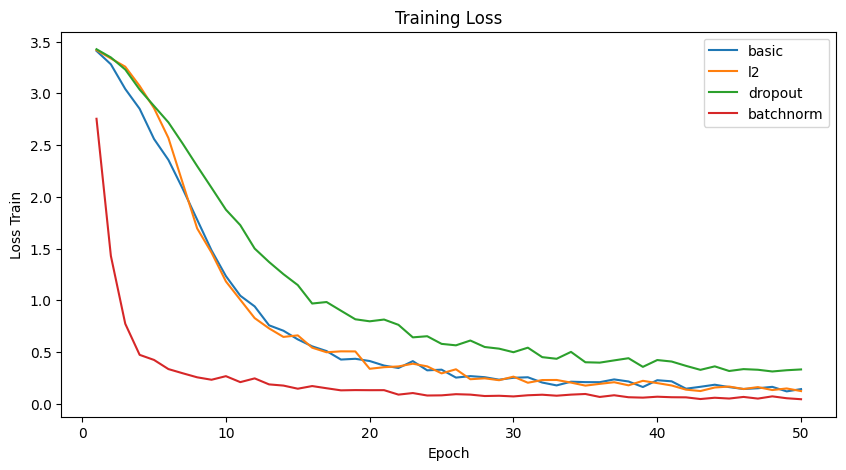

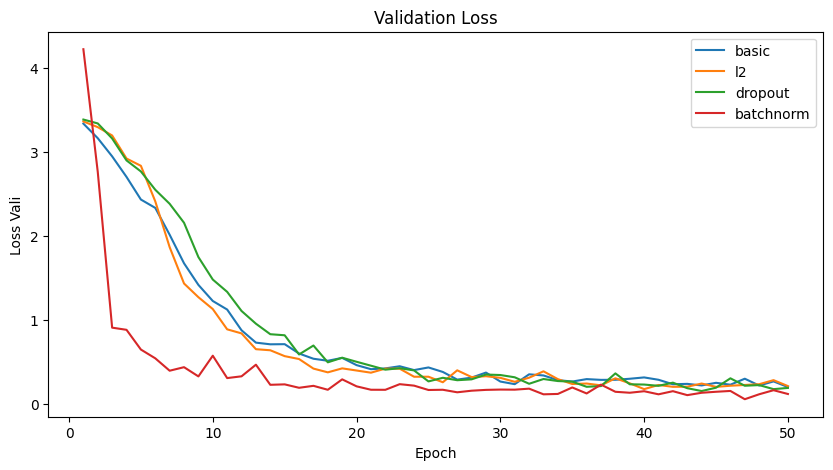

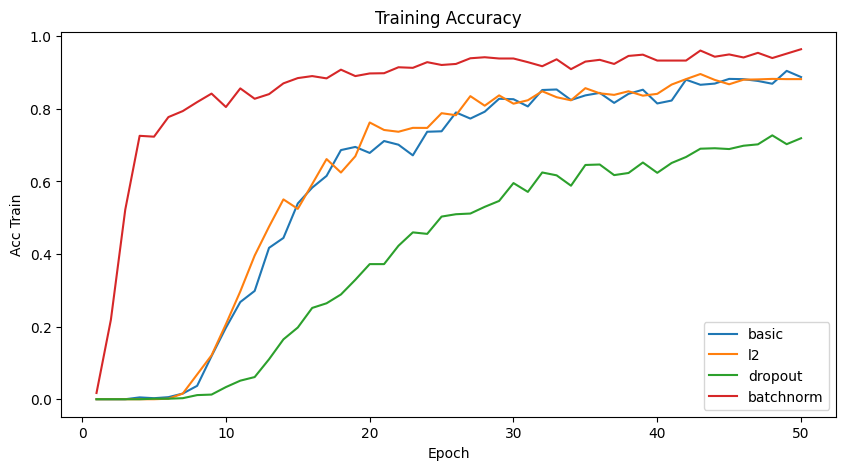

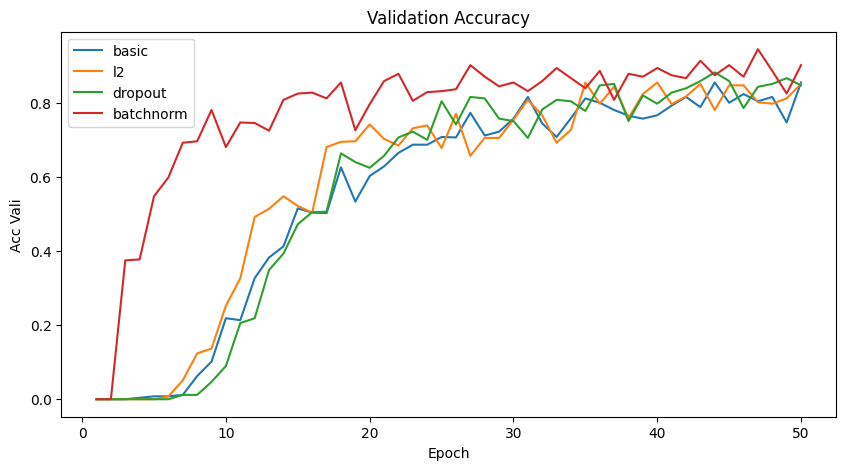

In [17]:
# Plot training/validation curves for all models

def _plot_histories(histories, keys, title):
    plt.figure(figsize=(10, 5))
    for label, hist in histories.items():
        xs = [h['epoch'] for h in hist]
        ys = [h[keys] for h in hist]
        plt.plot(xs, ys, label=label)
    plt.xlabel('Epoch')
    plt.ylabel(keys.replace('_', ' ').title())
    plt.title(title)
    plt.legend()
    plt.show()

histories_all = {
    'basic': history_basic,
    'l2': history_l2,
    'dropout': history_dropout,
    'batchnorm': history_bn,
}

_plot_histories(histories_all, 'loss_train', 'Training Loss')
_plot_histories(histories_all, 'loss_vali', 'Validation Loss')
_plot_histories(histories_all, 'acc_train', 'Training Accuracy')
_plot_histories(histories_all, 'acc_vali', 'Validation Accuracy')



=== Evaluating basic model ===
Starting evaluation epoch 1/1 ...


100%|██████████| 8/8 [00:00<00:00, 142.69it/s]


Ending evaluation of epoch 1/1 ...

# of test CAPTCHAs: 228
# correctly recognized: 185
Accuracy: 0.8114035087719298 

Figure(2000x500)
Figure(2000x600)

=== Evaluating l2 (weight decay) model ===
Starting evaluation epoch 1/1 ...


100%|██████████| 8/8 [00:00<00:00, 149.53it/s]

Ending evaluation of epoch 1/1 ...

# of test CAPTCHAs: 228
# correctly recognized: 189
Accuracy: 0.8289473684210527 



Figure(2000x500)
Figure(2000x600)

=== Evaluating dropout model ===
Starting evaluation epoch 1/1 ...


100%|██████████| 8/8 [00:00<00:00, 160.00it/s]

Ending evaluation of epoch 1/1 ...

# of test CAPTCHAs: 228
# correctly recognized: 191
Accuracy: 0.8377192982456141 

Figure(2000x500)


Figure(2000x600)

=== Evaluating batchnorm model ===
Starting evaluation epoch 1/1 ...


100%|██████████| 8/8 [00:00<00:00, 158.95it/s]

Ending evaluation of epoch 1/1 ...

# of test CAPTCHAs: 228
# correctly recognized: 200
Accuracy: 0.8771929824561403 

Figure(2000x500)


Figure(2000x600)


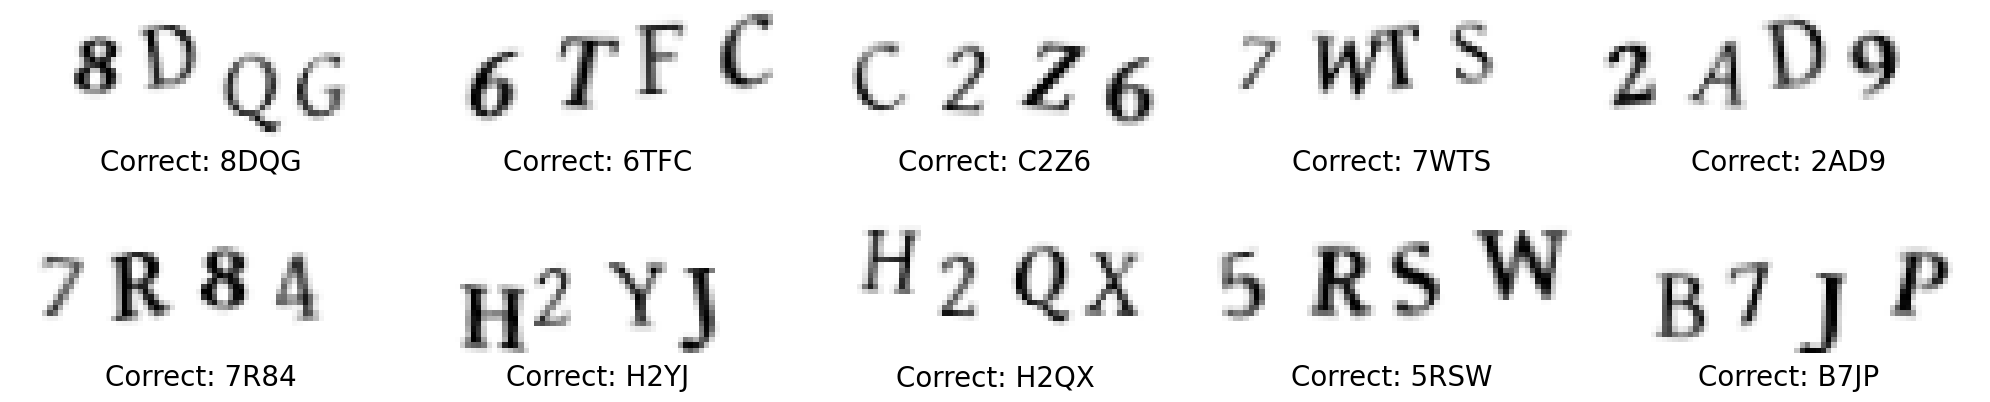

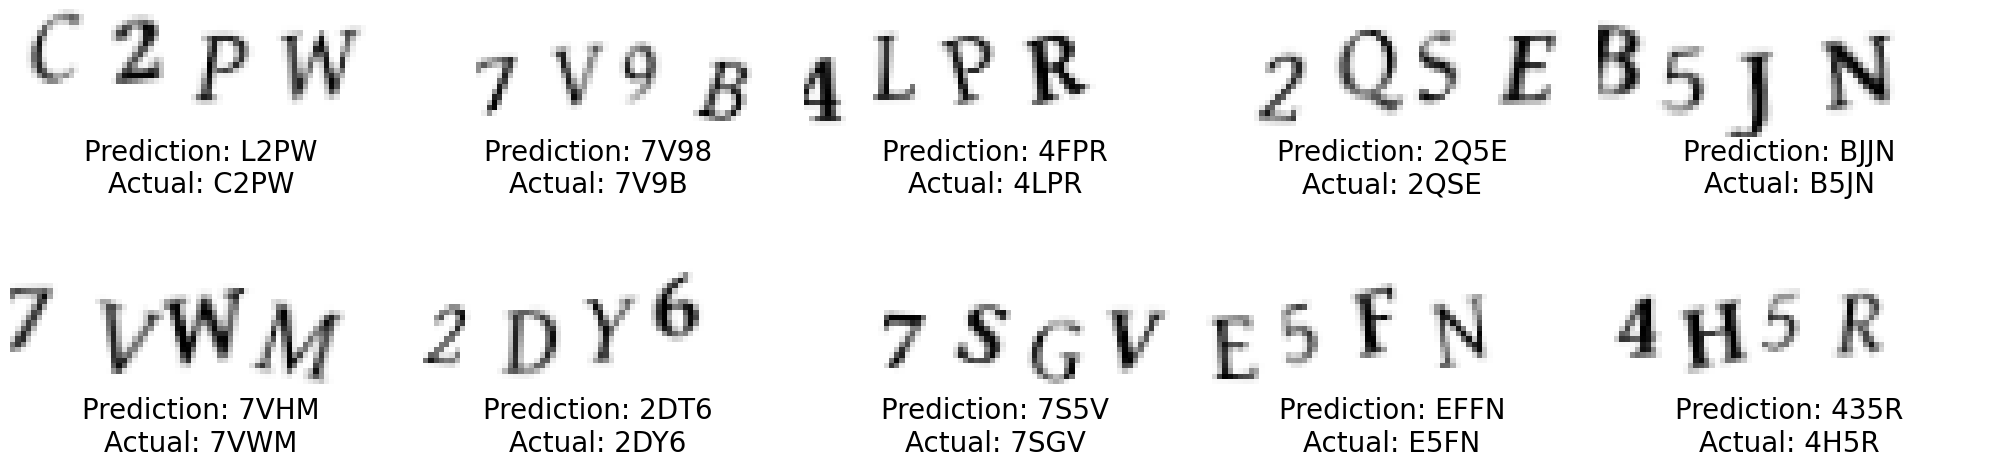

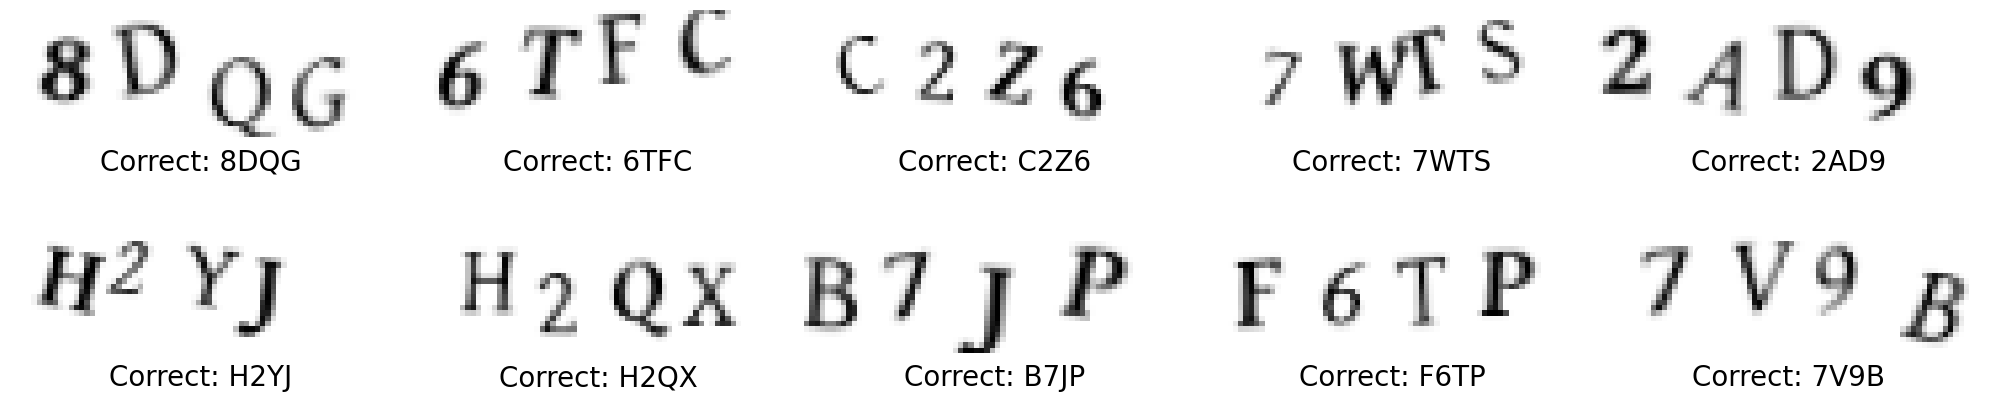

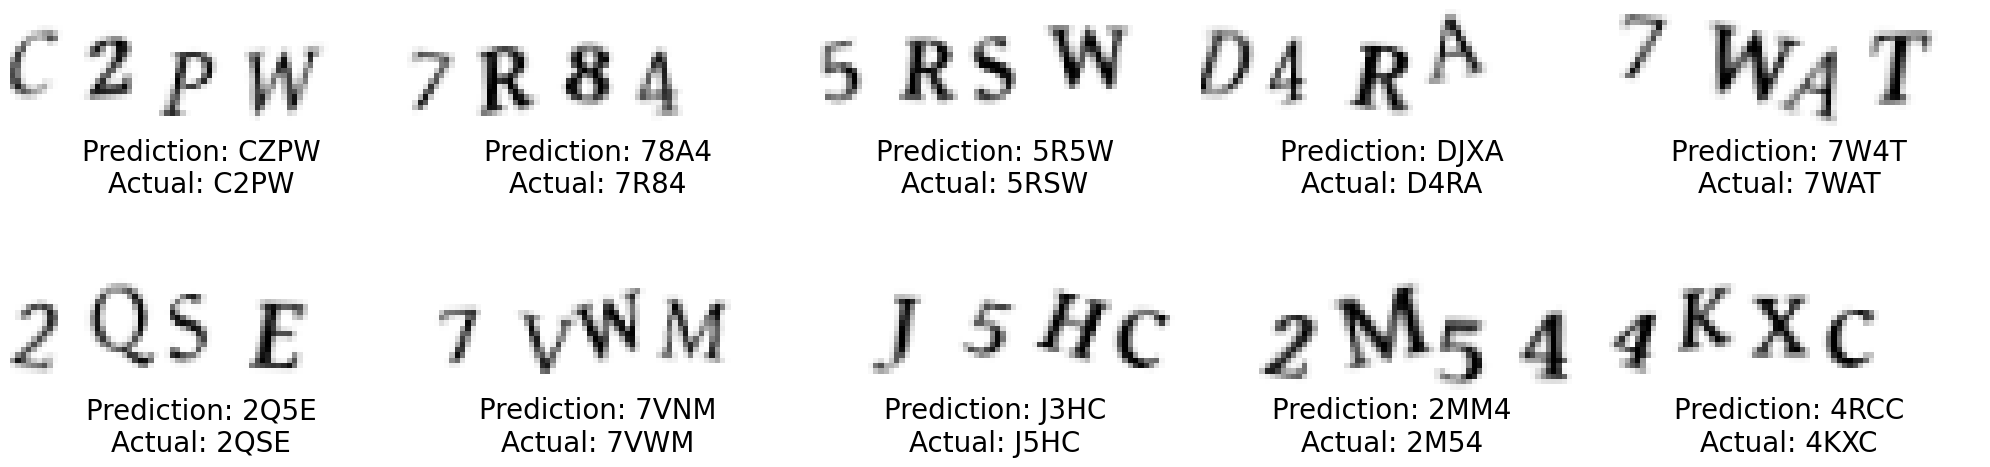

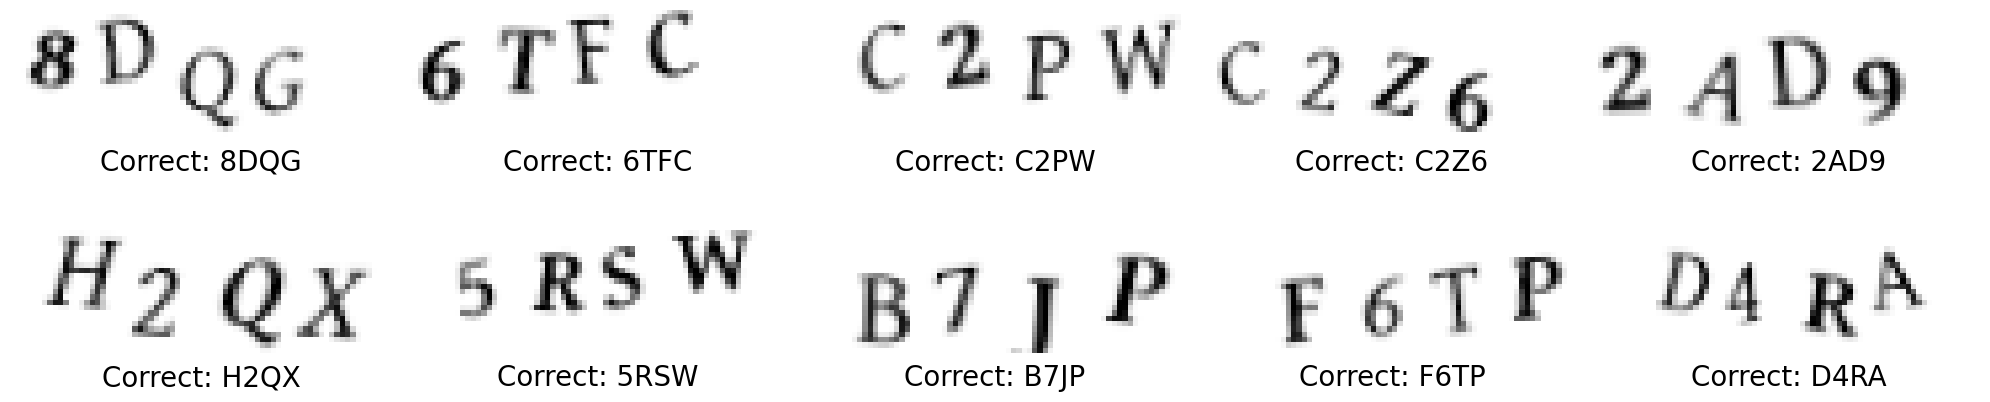

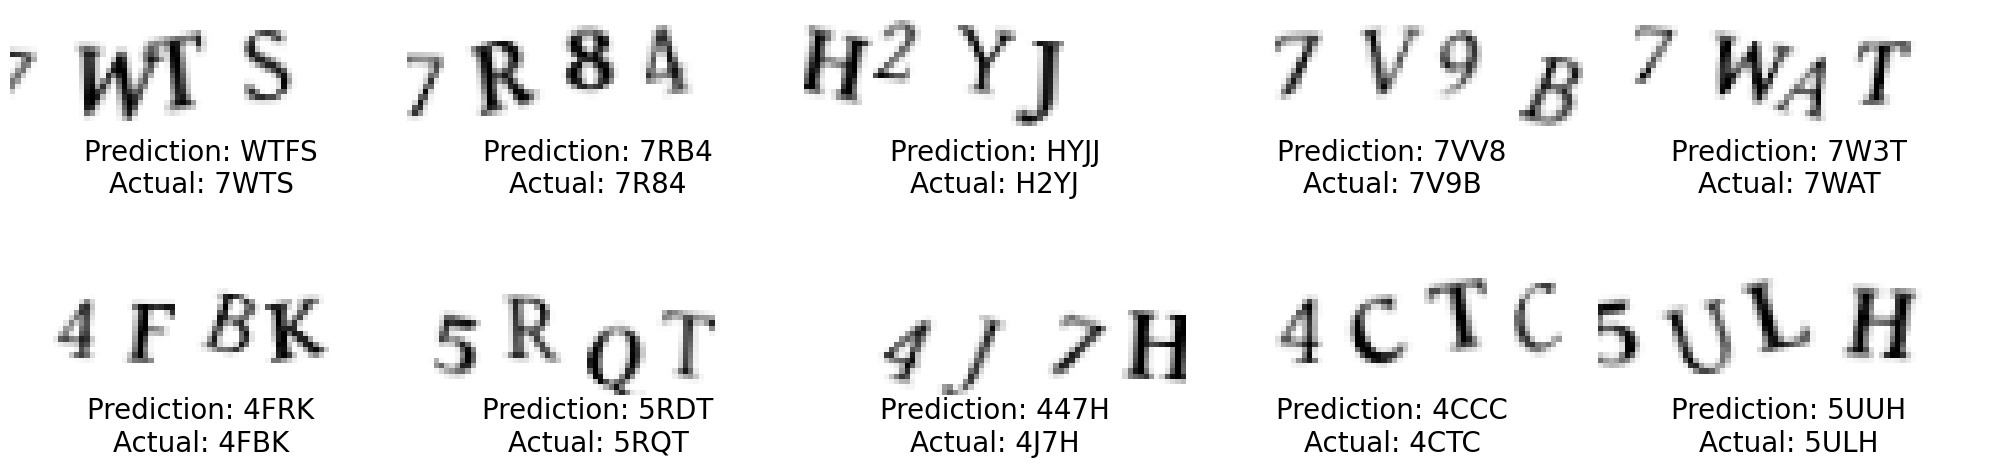

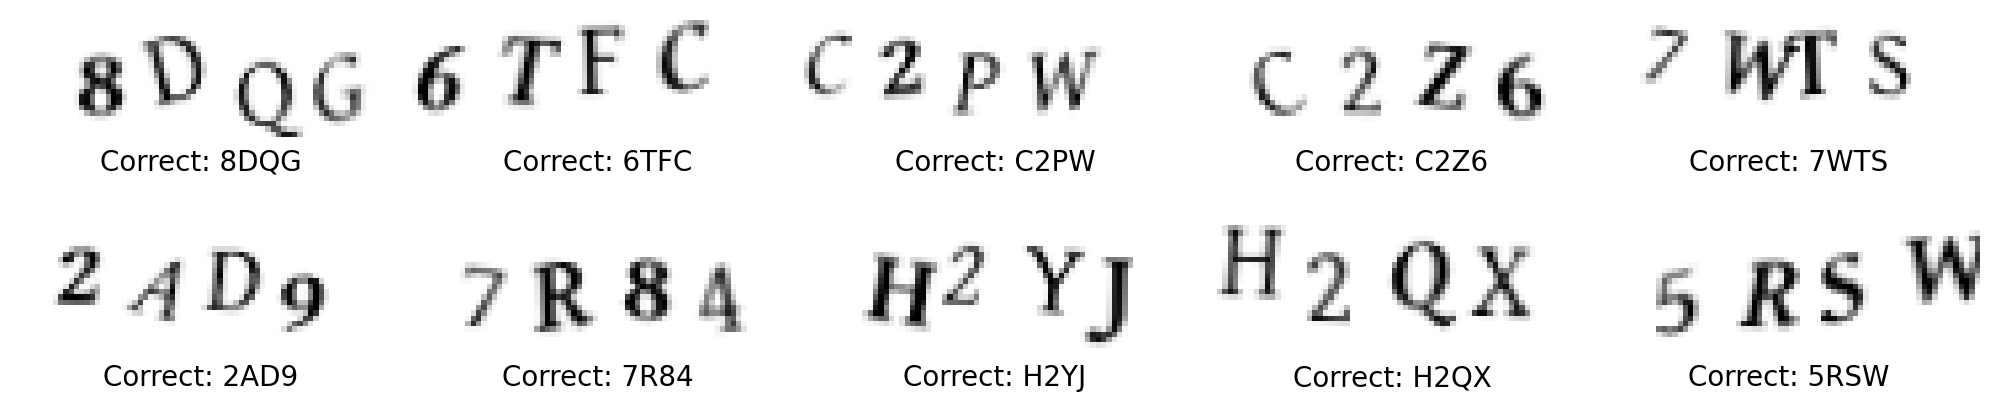

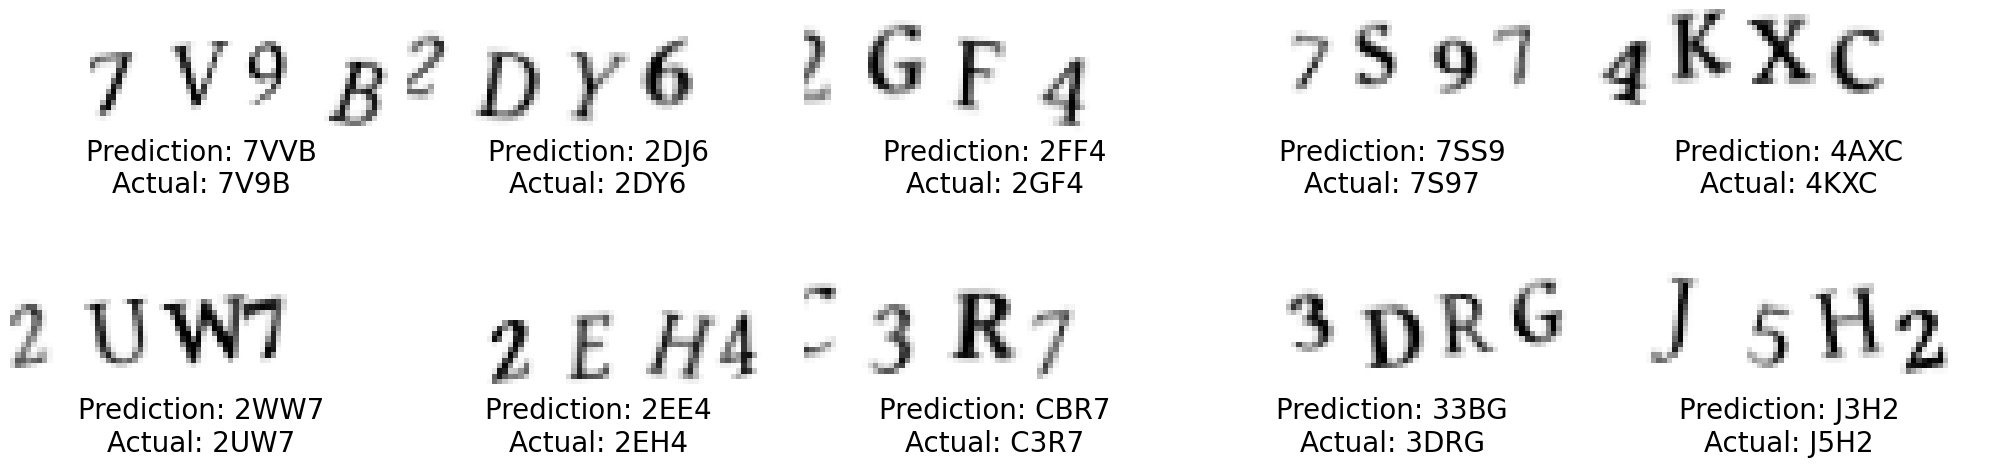

In [18]:
# Evaluate all models on the test set

def evaluate_and_report(model, name):
    print(f"\n=== Evaluating {name} model ===")
    evaluate_model(model, le, dataset_eval, batch_size=32, n_epochs=1, n_display_samples=10, device=torch_device)

evaluate_and_report(model_basic, 'basic')
evaluate_and_report(model_l2, 'l2 (weight decay)')
evaluate_and_report(model_dropout, 'dropout')
evaluate_and_report(model_bn, 'batchnorm')


## Submission

When you’re done, push this completed notebook (including all code and discussion answers) to your GitHub repo, then submit the repo link on the Canvas submission page.


## References

1. PyTorch API reference: https://pytorch.org/docs/stable/index.html
2. PyTorch Neural Network Modules: https://pytorch.org/docs/stable/nn.html
3. Over-fitting: https://en.wikipedia.org/wiki/Overfitting
4. Residual neural network: https://en.wikipedia.org/wiki/Residual_neural_network
5. Residual blocks - Building blocks of ResNet: https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec